# Plot Proper Motion Diagram

Examples of proper motion diagram to make the distinction between an object from the background or comoving with the star for the targets from the sample Super-Earth survey:

Based on Arthur Vigans's script "proper_motion.py". 

Last modification: June 1st, 2021 - Célia Desgrange

-> understood ANDROMEDA charac convention

## Import packages

In [ ]:
from import_packages_generic import *
from import_functions_generic import *
from import_functions_specific_PMD import *
from import_initialization_generic_variables import *
from import_initialization_dataframes import *

In [1]:
# my classic importations - all importations might not be relevant here
import numpy as np
from scipy import optimize, interpolate
from scipy.interpolate import RectBivariateSpline as rbs
#from sympy import *#symbols,diff,sin,cos,sqrt,Symbol,Derivative,log,sympify
import pandas as pd
import random
import cmath as cmath
from glob import glob
from astropy.io import fits
import astropy.constants as cst
#import vip_hci as vip

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, NullLocator, FormatStrFormatter, AutoMinorLocator,AutoLocator,LogFormatter,LogLocator,MaxNLocator)
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.axes import Axes
from matplotlib import colors
import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Arrow, Circle, ArrowStyle, FancyArrowPatch
from matplotlib.font_manager import FontProperties
from matplotlib.axes import rcParams
plt.style.use('classic')
mpl.rc('image', cmap='magma')#, origin='lower')
rcParams.update({'font.size': 14,  'axes.labelsize' : 14, 'legend.fontsize' : 12,
"font.family": "serif", 'text.usetex' : True, "font.serif": [], "font.sans-serif": [],
'legend.handlelength': 1., 'legend.borderaxespad' : 0.8, 'legend.columnspacing' : 0.5, 'legend.handletextpad' : 0.5})          
rcParams['mathtext.fontset'] = 'stix'

In [2]:
# specific importations for this Jupyter notebook
import proper_motion
#import query_gaia

# Some astro stuff
import datetime as dt
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy import units as u
import astropy.io.fits as fits
from astropy.constants import c
from astropy.time import Time
from astroquery.skyview import SkyView
from astroquery.vizier import Vizier
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad

# Query Simbad -> retrieve RA, DEC, and proper motion from the star 
customSimbad = Simbad()
fields = ['flux(V)','flux(G)','flux(R)','flux(J)','flux(H)','flux(K)',\
          'flux_error(V)','flux_error(G)','flux_error(R)','flux_error(J)',\
          'flux_error(H)','flux_error(K)',\
          'sp','pmra','pmdec',\
          'ra(gal)','dec(gal)',\
          'pm_err_angle','pm_err_maja','pm_err_mina','pm_bibcode','pm_qual',\
          'plx','plx_error','plx_bibcode',\
          'rv_value','rvz_error','rvz_qual','rvz_bibcode','rvz_radvel']

customSimbad.add_votable_fields(*fields)

keys = ['RA','DEC',\
        'PMRA','PMDEC','PM_ERR_MAJA','PM_ERR_MINA','PM_ERR_ANGLE','PM_QUAL','PM_BIBCODE',\
        'PLX_VALUE','PLX_ERROR',\
        'RA_gal','DEC_gal']

## Functions

In [3]:
# General functions to make nice plot
def mise_en_page(ax,x_min_step=0.2,x_maj_step=1,y_maj_step=1,y_min_step=0.2, x_step=0, y_step=0, grid_maj=0, grid_min=0):
    ax.tick_params(axis='x',which='major', width=1.3,length=8)
    ax.tick_params(axis='x',which='minor', width=1,length=5)   
    ax.tick_params(axis='y',which='major', width=1.3,length=8)
    ax.tick_params(axis='y',which='minor', width=1,length=5)   
    
    if x_step :
        ax.xaxis.set_major_locator(plt.MultipleLocator(x_maj_step))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(x_min_step))
    if y_step :
        ax.yaxis.set_major_locator(plt.MultipleLocator(y_maj_step))
        ax.yaxis.set_minor_locator(plt.MultipleLocator(y_min_step))
    if grid_maj : 
        ax.grid(which='major',color=[0.5,0.5,0.5],ls='-')
    if grid_min : 
        ax.grid(which='minor',color=[0.8,0.8,0.8],ls='-')
    return

def fais_moi_un_subplot(ax,X,Y,labx='',laby='',tit='',xlim=None,ylim=None,xlog=False,ylog=False,
                        xti_old=None,xti_new=None,yti_old=None,yti_new=None,
                        dx=0,dy=0,grid_maj=0,superpo=False,lab='',leg=False,loc=0,
                        c=[0,0,1],lw=1,ls='dotted',siz='3',mkr=None,fs=14): 

    if dx != 0 or dy != 0 : 
        ax.errorbar(X,Y,dy,dx,mkr,markersize=siz,label=lab,c=c)    
    else :
        ax.plot(X,Y,color=c,ls=ls,ms=10,label=lab,lw=lw)    
    if xti_new != xti_old: 
        plt.setp(ax, xticks=xti_old, xticklabels=xti_new)
    if yti_new != yti_old:
        plt.setp(ax, yticks=yti_old, yticklabels=yti_new)
    if xlog : ax.set_xscale('log')
    if ylog : ax.set_yscale('log')
    if leg : plt.legend(loc=loc,fontsize=fs-2)
    if xlim != None : ax.set_xlim(xlim)
    if ylim != None : ax.set_ylim(ylim)
    mise_en_page(ax,x_min_step=0.2,x_maj_step=1,y_maj_step=1,y_min_step=0.2, x_step=0, y_step=0, grid_maj=grid_maj, grid_min=0)
    ax.set_xlabel(labx,fontsize=fs)
    ax.set_ylabel(laby,fontsize=fs)
    ax.set_title(tit,fontsize=fs)
    ax.tick_params(labelsize=fs)
    return 

def legend_without_duplicate_labels(ax,loc=0,numpoints=1,ncol=1,frameon=True):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),numpoints=numpoints,ncol=ncol,loc=loc,frameon=frameon)

In [4]:
# Functions to convert easily units - might not be useful here
def sep2au(sep,d=10):
    '''
    Convert angular separation 'sep' (in arcsecond) to astrononomical unit 
    for a system located at a distance 'd_object' (in parsec).
    Note: d_object is a parameter defined by the class 'Object'. 
    The user should update the parameters of the class 'Object' accordingly.      
    '''
    return sep*d

def convert_ax_sep_to_au(ax):
    '''
    Add to the already defined axis 'ax' a second horizontal axis corresponding 
    to the distance in astronomical unit.
    Require the funtion 'sep2au'.
    '''
    y1, y2 = ax.get_xlim()
    ax1.set_xlim(sep2au(y1), sep2au(y2))
    ax1.figure.canvas.draw()
    return

def contr2mag(contr):
    '''
    Convert contrast 'contr' to magnitude.
    '''
    return -2.5*np.log10(contr)

def convert_ax_contr_to_mag(ax):
    '''
    Add to the already defined axis 'ax' a second vertical axis corresponding 
    to the magnitude.
    Require the funtion 'contr2mag'.
    '''
    x1, x2 = ax.get_ylim()
    ax2.set_ylim(contr2mag(x1), contr2mag(x2))
    ax2.figure.canvas.draw()
    return

In [5]:
# Functions to convert easily units - might not be useful here
def au2sep(au,d=10):
    '''
    Convert astrononomical unit to angular separation 'sep' (in arcsecond)
    for a system located at a distance 'd_object' (in parsec).
    Note: d_object is a parameter defined by the class 'Object'. 
    The user should update the parameters of the class 'Object' accordingly.      
    '''
    return au/d

def convert_ax_sep_to_au(ax):
    '''
    Add to the already defined axis 'ax' a second horizontal axis corresponding 
    to the distance in astronomical unit.
    Require the funtion 'au2sep'.
    '''
    y1, y2 = ax.get_xlim()
    ax1.set_xlim(au2sep(y1), au2sep(y2))
    ax1.figure.canvas.draw()
    return

def mag2contr(mag):
    '''
    Convert magnitude 'mag' to contrast.
    '''
    return 10**(-mag/2.5)

def convert_ax_mag_to_contr(ax):
    '''
    Add to the already defined axis 'ax' a second vertical axis corresponding 
    to the contrast.
    Require the funtion 'mag2contr'.
    '''
    x1, x2 = ax.get_ylim()
    ax2.set_ylim(mag2contr(x1), mag2contr(x2))
    ax2.figure.canvas.draw()
    return

In [6]:
# Additional functions to convert easily units - might not be useful here
def parallax2parsec(parallax):
    '''
    Convert parallax 'parallax' (in arcseconds) of a given system to its distance (in parsecs).
    '''
    return 1/parallax

def distance(x,y,x0=0,y0=0,pixarc=12.25):
    '''
    Convert distance between coordinates 'x' vs 'x0', 'y' vs 'y0' (in pixels) 
    into its distance in mas by using the conversion factor 'pixarc' 1 pix = ? mas.
    '''
    return np.sqrt((x-x0)**2+(y-y0)**2)*pixarc

# Initialization

In [7]:
# General parameters from the instrument
instru = 'SPHERE-IRDIS'
IWA_size = 0.1 # inner working angle from the coronagraph in arcsec
pixarc_ird = 12.25 ; pixarc_ifs = 7.43

# General convertion factors
MSun2MJup = 1052.6315784211
MSun2MEarth = MSun2MJup*318

# Error
# define global error budget in RA, DEC
# add the pupil offset error of theta = 0.1 deg; depends on sep (separation) and differs for ra/dec
# error in ra: dra**2 =  [sin(theta)*dsep]**2 + [sep*cos(theta)*dtheta]**2 
# error in dec: ddec**2 =  [cos(theta)*dsep]**2 + [sep*sin(theta)*dtheta]**2 
theta     = 135.99 * np.pi/180 # 0.1 error pupil offset converted in rad
theta_err = 0.11 * np.pi/180 

In [8]:
infolder_super_earths = '/Users/user/Documents/desgrange/super-earths/'
folder_download_and_diplay = 'download_and_display_scripts/'
folder_data_scripts   = 'download_and_display_scripts/download_scripts/'
folder_sphere_DC_data = 'download_and_display_scripts/SPHERE_DC_DATA/'
folder_all_specal_charac = '*charac*/*/*/'

list_obj_obs  = 'csv_tables/manual_statistics_for_wiki_working_document_v3.csv'
list_obj_prop = 'csv_tables/names.csv'
list_obj_specalcharac = 'comp_astro_photo_tdb.csv'

In [9]:
# Read tables corresponding to the Super-Earth survey
# Table listing all the observations
dF_obs  = pd.read_csv(infolder_super_earths+list_obj_obs,sep=';')
NIGHT_OBS = np.array(dF_obs['night_obs'])
# Table summarizing the target properties
dF_prop = pd.read_csv(infolder_super_earths+list_obj_prop,sep=';')
dF_prop_name_cols = dF_prop.columns
NAME_OBJ  = np.array(dF_prop['target name'])
DISTANCE  = np.array(dF_prop['distance'])
PARALLAX  = np.array(dF_prop['parallax']) ; PARALLAX_ERR  = np.array(dF_prop['err parallax'])
MAG_STAR_J, MAG_STAR_H, MAG_STAR_K =  np.array(dF_prop['mag star J']), np.array(dF_prop['mag star H']), np.array(dF_prop['mag star K'])

In [10]:
dF_obs.iloc[0,:]['target name DC']

'HIP 48331'

### Initialize for all the detections in the Super-Earth survey the magnitude in H2,H3 and K1,K2-bands

Note: all detections are from specal charac files

In [11]:
files = infolder_super_earths + folder_sphere_DC_data + folder_all_specal_charac + list_obj_specalcharac

# Initialization lists for magnitudes(+err): relative, apparent, absolute
MAG_REL_H2, MAG_REL_H3, MAG_REL_K1, MAG_REL_K2 = [], [], [], []
MAG_REL_ERR_H2, MAG_REL_ERR_H3, MAG_REL_ERR_K1, MAG_REL_ERR_K2 = [], [], [], []
MAG_APP_H2_companion, MAG_APP_H3_companion, MAG_APP_K1_companion, MAG_APP_K2_companion = [], [], [], []
MAG_APP_ERR_H2_companion, MAG_APP_ERR_H3_companion, MAG_APP_ERR_K1_companion, MAG_APP_ERR_K2_companion = [], [], [], []
MAG_ABS_H2_companion, MAG_ABS_H3_companion, MAG_ABS_K1_companion, MAG_ABS_K2_companion = [], [], [], []
MAG_ABS_ERR_H2_companion, MAG_ABS_ERR_H3_companion, MAG_ABS_ERR_K1_companion, MAG_ABS_ERR_K2_companion = [], [], [], []

TARGET_MAG_H23, TARGET_MAG_K12 = [], []
SNR_H23, SNR_K12 = [], []
NAME_H23, NAME_K12 = [], []
X_MAS_H23, Y_MAS_H23 = [],[] ; X_MAS_K12, Y_MAS_K12 = [],[]
X_MAS_ERR_H23, Y_MAS_ERR_H23 = [],[] ; X_MAS_ERR_K12, Y_MAS_ERR_K12 = [],[]

SEP_H23, PA_H23 = [],[] ; SEP_K12, PA_K12 = [],[]
SEP_ERR_H23, PA_ERR_H23 = [],[] ; SEP_ERR_K12, PA_ERR_K12 = [],[]

DISTANCE_H23, DISTANCE_K12 = [], []
MAG_STAR_H23, MAG_STAR_K12 = [], []

for name in glob(files): 
    print('\n',name)
    dF = pd.read_csv(name,sep=',')
    name_target = dF['target'][0].replace('-','')
    if name_target == 'HD285968': 
        name_target = 'GJ176'
    elif name_target == 'GJ667C':
        name_target = 'GJ667'
    elif name_target == 'HD42581':
        name_target = 'GJ229'
    
    #name_target_csv = ' ' +name_target+ ' '
    #print('target', name_target, 'd_star', d_star)
    parallax_star = float(dF_prop[dF_prop['target name']==name_target]['parallax'])*1e-3
    parallax_err_star = float(dF_prop[dF_prop['target name']==name_target]['err parallax'])*1e-3
    d_star = 1/parallax_star
    d_err_star = parallax_err_star/parallax_star**2
    print('target', name_target, 'd_star', d_star, 'd_err_star', d_err_star)
    
    n = len(dF)//2
    print('n',n)
    for i in range(n):
        if dF["filter"][0] == 'DB_H23' and dF["snr"][i] >= 3 : #and dF['algorithm'][0] == 'Classical_ADI': 
            mag_star_H = float(dF_prop[dF_prop['target name']==name_target]['mag star H'])
            # relative magnitude
            MAG_REL_H2.append(dF["mag"][i]); MAG_REL_H3.append(dF["mag"][i+n])
            MAG_REL_ERR_H2.append(dF["magerr"][i]); MAG_REL_ERR_H3.append(dF["magerr"][i+n])
            # sometimes error overestimated because psf luminosity variates deeply between beginning 
            # and end of the observing sequence -> remove the "mag error psf" from the total error budget
            if dF['magerrpsf'][i] > 1 or dF['magerrpsf'][i+n] > 1 :
                MAG_REL_ERR_H2[-1] -= dF['magerrpsf'][i]*0.95
                MAG_REL_ERR_H3[-1] -= dF['magerrpsf'][i+n]*0.95
            # apparent magnitude
            MAG_APP_H2_companion.append(mag_star_H+MAG_REL_H2[-1])
            MAG_APP_H3_companion.append(mag_star_H+MAG_REL_H3[-1])
            # absolute magnitude
            MAG_ABS_H2_companion.append(MAG_APP_H2_companion[-1]-5*np.log10(d_star/10.))
            MAG_ABS_H3_companion.append(MAG_APP_H3_companion[-1]-5*np.log10(d_star/10.))
            # err
            MAG_ABS_ERR_H2_companion.append(np.sqrt(MAG_REL_ERR_H2[-1]**2 + (5*d_err_star/(d_star*np.log(10)))**2))
            MAG_ABS_ERR_H3_companion.append(np.sqrt(MAG_REL_ERR_H3[-1]**2 + (5*d_err_star/(d_star*np.log(10)))**2))
            print('mag abs=','%.1f'%MAG_ABS_H2_companion[-1],
                  '; color=%.1f'%(MAG_ABS_H2_companion[-1]-MAG_ABS_H3_companion[-1]),
                  '; mag err H2=','%.2f'%MAG_ABS_ERR_H2_companion[-1],'err H3=%.2f'%MAG_ABS_ERR_H3_companion[-1],
                  '; magerrpsf H2=', dF['magerrpsf'][i],'magerrpsf H3=', dF['magerrpsf'][i+n], 
                  '; snr=',  dF['snr'][i+n])
            # trace the target name
            TARGET_MAG_H23.append(name_target)
            # and its SNR
            SNR_H23.append([dF["snr"][i],dF["snr"][n+i]])
            #print('M_H2',MAG_ABS_H2_companion[-1], 'H2-H3', MAG_ABS_H2_companion[-1]-MAG_ABS_H3_companion[-1])
            # position
            X_MAS_H23.append(dF["xpos"][i]), Y_MAS_H23.append(dF["ypos"][i])
            X_MAS_ERR_H23.append(dF["xposerr"][i]), Y_MAS_ERR_H23.append(dF["yposerr"][i])
            SEP_H23.append(dF["sepa"][i]), PA_H23.append(dF["pa"][i])
            SEP_ERR_H23.append(dF["sepaerr"][i]), PA_ERR_H23.append(dF["paerr"][i])
            # other
            NAME_H23.append(name)
            DISTANCE_H23.append(d_star)
            MAG_STAR_H23.append(mag_star_H)

                
            
        elif dF["filter"][0] == 'DB_K12' and dF["snr"][i] >= 3 : 
            mag_star_K = float(dF_prop[dF_prop['target name']==name_target]['mag star K'])
            # relative magnitude
            MAG_REL_K1.append(dF["mag"][i]); MAG_REL_K2.append(dF["mag"][i+n])
            MAG_REL_ERR_K1.append(dF["magerr"][i]); MAG_REL_ERR_K2.append(dF["magerr"][i+n])
            # sometimes error overestimated because psf luminosity variates deeply between beginning 
            # and end of the observing sequence -> remove the "mag error psf" from the total error budget
            if dF['magerrpsf'][i] > 1 or dF['magerrpsf'][i+n] > 1 :
                MAG_REL_ERR_K1[-1] -= dF['magerrpsf'][i]*0.95
                MAG_REL_ERR_K2[-1] -= dF['magerrpsf'][i+n]*0.95
            # apparent magnitude
            MAG_APP_K1_companion.append(mag_star_K+MAG_REL_K1[-1])
            MAG_APP_K2_companion.append(mag_star_K+MAG_REL_K2[-1])
            # absolute magnitude
            MAG_ABS_K1_companion.append(MAG_APP_K1_companion[-1]-5*np.log10(d_star/10.))
            MAG_ABS_K2_companion.append(MAG_APP_K2_companion[-1]-5*np.log10(d_star/10.))
            # err
            MAG_ABS_ERR_K1_companion.append(np.sqrt(MAG_REL_ERR_K1[-1]**2 + (5*d_err_star/(d_star*np.log(10)))**2))
            MAG_ABS_ERR_K2_companion.append(np.sqrt(MAG_REL_ERR_K2[-1]**2 + (5*d_err_star/(d_star*np.log(10)))**2))
            # trace the target name
            TARGET_MAG_K12.append(name_target)
            # and its SNR
            SNR_K12.append([dF["snr"][i],dF["snr"][n+i]])
            # position
            #print('M_K1',MAG_ABS_H2_companion[-1], 'K1-K2', MAG_ABS_K1_companion[-1]-MAG_ABS_K2_companion[-1])
            X_MAS_K12.append(dF["xpos"][i]), Y_MAS_K12.append(dF["ypos"][i])
            X_MAS_ERR_K12.append(dF["xposerr"][i]), Y_MAS_ERR_K12.append(dF["yposerr"][i])
            SEP_K12.append(dF["sepa"][i]), PA_K12.append(dF["pa"][i])
            SEP_ERR_K12.append(dF["sepaerr"][i]), PA_ERR_K12.append(dF["paerr"][i])
            # other
            NAME_K12.append(name)
            DISTANCE_K12.append(d_star)
            MAG_STAR_K12.append(mag_star_K)
            print(#'mag rel err K1','%.2f'%MAG_REL_ERR_K1[-1],'K2','%.2f'%MAG_REL_ERR_K2[-1], 
                  'mag abs=','%.1f'%MAG_ABS_K1_companion[-1],
                  '; color=%.1f'%(MAG_ABS_K1_companion[-1]-MAG_ABS_K2_companion[-1]),
                  '; mag err K1=','%.2f'%MAG_ABS_ERR_K1_companion[-1],'err K2=%.2f'%MAG_ABS_ERR_K2_companion[-1],
                  '; magerrpsf K1=', dF['magerrpsf'][i],'magerrpsf K2=', dF['magerrpsf'][i+n], 
                  '; magerrseq K2=%.2f'% dF['magerrseq'][i+n],'; magerrfit K2=%.2f'% dF['magerrfit'][i+n],
                  '; snr=',  dF['snr'][i+n],
                  ' with',dF['algorithm'][0],
                  ' at xpix','%.1f'%(724-X_MAS_K12[-1]/pixarc_ird-1),'ypix','%.1f'%(724+Y_MAS_K12[-1]/pixarc_ird+1),
                 )
            

MAG_ABS_H2_companion = np.array(MAG_ABS_H2_companion) ; MAG_ABS_H3_companion = np.array(MAG_ABS_H3_companion)
MAG_ABS_K1_companion = np.array(MAG_ABS_K1_companion) ; MAG_ABS_K2_companion = np.array(MAG_ABS_K2_companion)

MAG_APP_ERR_H2_companion = np.array(MAG_APP_ERR_H2_companion) ; MAG_APP_ERR_H3_companion = np.array(MAG_APP_ERR_H3_companion)
MAG_APP_ERR_K1_companion = np.array(MAG_APP_ERR_K1_companion) ; MAG_APP_ERR_K2_companion = np.array(MAG_APP_ERR_K2_companion)

MAG_ABS_ERR_H2_companion = np.array(MAG_ABS_ERR_H2_companion) ; MAG_ABS_ERR_H3_companion = np.array(MAG_ABS_ERR_H3_companion)
MAG_ABS_ERR_K1_companion = np.array(MAG_ABS_ERR_K1_companion) ; MAG_ABS_ERR_K2_companion = np.array(MAG_ABS_ERR_K2_companion)

MAG_REL_ERR_H2, MAG_REL_ERR_H3 = np.array(MAG_REL_ERR_H2), np.array(MAG_REL_ERR_H3)
MAG_REL_ERR_K1, MAG_REL_ERR_K2 = np.array(MAG_REL_ERR_K1), np.array(MAG_REL_ERR_K2)

TARGET_MAG_H23 = np.array(TARGET_MAG_H23) ; TARGET_MAG_K12 = np.array(TARGET_MAG_K12)
SNR_H23, SNR_K12 = np.array(SNR_H23), np.array(SNR_K12)
DISTANCE_H23 = np.array(DISTANCE_H23); DISTANCE_K12 = np.array(DISTANCE_K12)
MAG_STAR_H23 = np.array(MAG_STAR_H23); MAG_STAR_K12 = np.array(MAG_STAR_K12)
color_H23 = MAG_ABS_H2_companion-MAG_ABS_H3_companion ; color_K12 = MAG_ABS_K1_companion-MAG_ABS_K2_companion

X_MAS_H23, Y_MAS_H23 = np.array(X_MAS_H23), np.array(Y_MAS_H23)
X_MAS_K12, Y_MAS_K12 = np.array(X_MAS_K12), np.array(Y_MAS_K12)
X_MAS_ERR_H23, Y_MAS_ERR_H23 = np.array(X_MAS_ERR_H23), np.array(Y_MAS_ERR_H23)
X_MAS_ERR_K12, Y_MAS_ERR_K12 = np.array(X_MAS_ERR_K12), np.array(Y_MAS_ERR_K12)


SEP_H23, PA_H23 = np.array(SEP_H23), np.array(PA_H23)
SEP_K12, PA_K12 = np.array(SEP_K12), np.array(PA_K12)
SEP_ERR_H23, PA_ERR_H23 = np.array(SEP_ERR_H23), np.array(PA_ERR_H23)
SEP_ERR_K12, PA_ERR_K12 = np.array(SEP_ERR_K12), np.array(PA_ERR_K12)

NAME_H23, NAME_K12 = np.array(NAME_H23), np.array(NAME_K12)


 /Users/user/Documents/desgrange/super-earths/download_and_display_scripts/SPHERE_DC_DATA/2019-11-25_ird_specalcharac_dc_223035/Reduction_0000/PointSource_astro_photo/comp_astro_photo_tdb.csv
target GJ422 d_star 12.675517896310208 d_err_star 0.005130153313293993
n 6
mag abs= 18.9 ; color=-0.1 ; mag err K1= 0.15 err K2=0.29 ; magerrpsf K1= 0.005 magerrpsf K2= 0.006 ; magerrseq K2=0.08 ; magerrfit K2=0.28 ; snr= 3.9  with Classical_ADI  at xpix 937.3 ypix 665.3
mag abs= 17.1 ; color=-0.1 ; mag err K1= 0.11 err K2=0.10 ; magerrpsf K1= 0.005 magerrpsf K2= 0.006 ; magerrseq K2=0.08 ; magerrfit K2=0.05 ; snr= 20.4  with Classical_ADI  at xpix 972.8 ypix 748.0
mag abs= 18.1 ; color=-0.0 ; mag err K1= 0.27 err K2=0.31 ; magerrpsf K1= 0.005 magerrpsf K2= 0.006 ; magerrseq K2=0.08 ; magerrfit K2=0.30 ; snr= 3.6  with Classical_ADI  at xpix 720.0 ypix 1167.0
mag abs= 19.5 ; color=-1.9 ; mag err K1= 0.28 err K2=3.14 ; magerrpsf K1= 0.005 magerrpsf K2= 0.006 ; magerrseq K2=0.08 ; magerrfit K2=3.13

mag abs= 20.2 ; color=0.0 ; mag err H2= 0.09 err H3=0.09 ; magerrpsf H2= 0.002 magerrpsf H3= 0.002 ; snr= 38.2
mag abs= 19.9 ; color=-0.0 ; mag err H2= 0.09 err H3=0.09 ; magerrpsf H2= 0.002 magerrpsf H3= 0.002 ; snr= 37.0
mag abs= 20.0 ; color=0.0 ; mag err H2= 0.09 err H3=0.09 ; magerrpsf H2= 0.002 magerrpsf H3= 0.002 ; snr= 35.7
mag abs= 20.4 ; color=-0.0 ; mag err H2= 0.09 err H3=0.10 ; magerrpsf H2= 0.002 magerrpsf H3= 0.002 ; snr= 29.2

 /Users/user/Documents/desgrange/super-earths/download_and_display_scripts/SPHERE_DC_DATA/2020-03-16_ird_specalcharac_dc_223264/Reduction_0000/PointSource_astro_photo/comp_astro_photo_tdb.csv
target HD136352 d_star 14.739112549189946 d_err_star 0.013045348396198198
n 7
mag abs= 18.3 ; color=-0.0 ; mag err K1= 0.11 err K2=0.31 ; magerrpsf K1= 0.001 magerrpsf K2= 0.002 ; magerrseq K2=0.04 ; magerrfit K2=0.31 ; snr= 3.5  with Classical_ADI  at xpix 680.6 ypix 550.3
mag abs= 19.1 ; color=0.5 ; mag err K1= 0.19 err K2=0.28 ; magerrpsf K1= 0.001 magerrp

target GJ229 d_star 5.761231852767802 d_err_star 0.0005659200614659548
n 1
mag abs= 21.4 ; color=0.0 ; mag err H2= 0.05 err H3=0.06 ; magerrpsf H2= 0.001 magerrpsf H3= 0.001 ; snr= 43.5

 /Users/user/Documents/desgrange/super-earths/download_and_display_scripts/SPHERE_DC_DATA/2018-11-27_ird_specalcharac_dc_212938/Reduction_0000/PointSource_astro_photo/comp_astro_photo_tdb.csv
target GJ229 d_star 5.761231852767802 d_err_star 0.0005659200614659548
n 1
mag abs= 14.9 ; color=-1.8 ; mag err H2= 0.05 err H3=0.05 ; magerrpsf H2= 0.001 magerrpsf H3= 0.001 ; snr= 96.6

 /Users/user/Documents/desgrange/super-earths/download_and_display_scripts/SPHERE_DC_DATA/2018-11-23_ird_specalcharac_dc_223100/Reduction_0000/PointSource_astro_photo/comp_astro_photo_tdb.csv
target HD38858 d_star 15.210374692370172 d_err_star 0.007107240907232104
n 1
mag abs= 18.2 ; color=0.1 ; mag err H2= 0.05 err H3=0.05 ; magerrpsf H2= 0.001 magerrpsf H3= 0.001 ; snr= 55.6

 /Users/user/Documents/desgrange/super-earths/downlo

mag abs= 18.4 ; color=0.1 ; mag err K1= 0.19 err K2=0.62 ; magerrpsf K1= 0.002 magerrpsf K2= 0.002 ; magerrseq K2=0.03 ; magerrfit K2=0.62 ; snr= 1.8  with Classical_ADI  at xpix 831.5 ypix 409.2
mag abs= 18.3 ; color=-1.5 ; mag err K1= 0.20 err K2=2.09 ; magerrpsf K1= 0.002 magerrpsf K2= 0.002 ; magerrseq K2=0.03 ; magerrfit K2=2.09 ; snr= 0.5  with Classical_ADI  at xpix 982.6 ypix 963.7
mag abs= 17.8 ; color=0.3 ; mag err K1= 0.14 err K2=0.33 ; magerrpsf K1= 0.002 magerrpsf K2= 0.002 ; magerrseq K2=0.03 ; magerrfit K2=0.33 ; snr= 3.3  with Classical_ADI  at xpix 824.8 ypix 322.2
mag abs= 18.7 ; color=0.3 ; mag err K1= 0.27 err K2=0.53 ; magerrpsf K1= 0.002 magerrpsf K2= 0.002 ; magerrseq K2=0.03 ; magerrfit K2=0.53 ; snr= 2.1  with Classical_ADI  at xpix 1101.9 ypix 918.8
mag abs= 18.4 ; color=-4.3 ; mag err K1= 0.20 err K2=34.14 ; magerrpsf K1= 0.002 magerrpsf K2= 0.002 ; magerrseq K2=0.03 ; magerrfit K2=34.14 ; snr= 0.0  with Classical_ADI  at xpix 435.2 ypix 365.1
mag abs= 14.5 ;

In [12]:
dF.iloc[0]

target                                                        HD85512
obs_id                                                        2260269
instrument                                                     SPHERE
setup                                                           IRDIS
obsdate                                                  58813.274398
filter                                                         DB_K12
angle                                                         6.95033
tn                                                              -1.75
tn_err                                                            0.0
scale                                                           12.25
scale_err                                                         0.0
software_name                                                  Specal
version                                                    2020-04-08
algorithm                                                         PCA
reduc_algo          

# Plot Proper Motion Diagramm

In [13]:
target = 'HD154088'
target_DC_all = dF_obs[target==dF_obs['target name']]['target name DC']
target_DC_all

8     HD 154088b
9     HD 154088b
70     HIP 83541
71     HIP 83541
90     HIP 83541
91     HIP 83541
Name: target name DC, dtype: object

# Peering into one targeted system

### A la mano

In [53]:
# A la mano GJ 832

target_DC = target_DC_all.iloc[0]

# initialize lists
##EPOCH_all, RA_all, DEC_all =[ '2017-05-27','2017-06-21','2017-06-27','2017-07-03'], [481.2,429,429,429], [197.7,291,291,291]
RA_ERR_all, DEC_ERR_all, X_all, Y_all = [10,10,10,10], [10,10,10,10], [30, 37,37,37], [121, 133.5,133.5]
EPOCH_all =  ['2021-06-21', '2021-06-27', '2021-07-03']
RA_all, DEC_all = [183.75,  104.125,  79.625], [  0.,     79.625, 104.125]
X_all, Y_all = [496.5, 503.,  505. ], [511.5, 518.,  520. ]

SEP_all, SEP_ERR_all, PA_all, PA_ERR_all = [distance(RA_all[0],DEC_all[0],0,0,1),distance(RA_all[1],DEC_all[1],0,0,1),distance(RA_all[1],DEC_all[1],0,0,1),distance(RA_all[1],DEC_all[1],0,0,1)], [15,15,15,15], [68,68,68,68], [30,30,30,30],

print('Target: {} (DC name: {}) \nNumber detections: {}'.format(target,target_DC, len(EPOCH_all)))
print('Epochs:', EPOCH_all[0])

print('RA:', RA_all , '\nDEC:', DEC_all) 
print('SEP:', SEP_all , '\nPA:', PA_all) 
#print('X', X_all , '\nY', Y_all)

Target: HD154088 (DC name: HD 154088b) 
Number detections: 3
Epochs: 2021-06-21
RA: [183.75, 104.125, 79.625] 
DEC: [0.0, 79.625, 104.125]
SEP: [183.75, 131.08072417407527, 131.08072417407527, 131.08072417407527] 
PA: [68, 68, 68, 68]


In [59]:
np.sqrt(200)

14.142135623730951

## Quasi-Automatized 

### Detections details
Are there any detections in H2 and K1 ? If yes, in which epoch, at which magnitudes and at which pixels???

In [60]:
target_DC = target_DC_all.iloc[0]

# initialize lists
EPOCH_all, RA_all, DEC_all, RA_ERR_all, DEC_ERR_all, X_all, Y_all = [], [], [], [], [], [], []
SEP_all, SEP_ERR_all, PA_all, PA_ERR_all = [], [], [], []
cond = (TARGET_MAG_H23 == target) 
#cond_interesting = (MAG_ABS_H2_companion < 16)
#cond = np.logical_and(cond,cond_interesting)

y = MAG_ABS_H2_companion[cond]
x = MAG_ABS_H2_companion[cond]-MAG_ABS_H3_companion[cond]

file_temporary = NAME_H23[cond]
EPOCH_all.append(np.array([file_temporary[i][89:99] for i in range(len(file_temporary))]))

print('Target: {} (DC name: {}) \nNumber detections: {}'.format(target,target_DC, len(EPOCH_all)),
      'including', len(TARGET_MAG_H23[cond]), 'interesting cases from a CMD point of view.\n')
print('Epochs:', EPOCH_all[0])

#print('Mag Rel', np.array(MAG_REL_H2)[cond])
print('H2-H3:',x, '\nM_H2:',y)

RA_all.append(X_MAS_H23[cond]); DEC_all.append(Y_MAS_H23[cond])
RA_ERR_all.append(X_MAS_ERR_H23[cond]); DEC_ERR_all.append(Y_MAS_ERR_H23[cond])
SEP_all.append(SEP_H23[cond]); SEP_ERR_all.append(SEP_ERR_H23[cond])

X_all.append(724-X_MAS_H23[cond]/pixarc_ird); Y_all.append(724+1+Y_MAS_H23[cond]/pixarc_ird)
print('RA:', RA_all , '\nDEC:', DEC_all) 
print('X', X_all , '\nY', Y_all)

Target: HD154088 (DC name: HD 154088b) 
Number detections: 1 including 32 interesting cases from a CMD point of view.

Epochs: ['2017-06-21' '2017-06-21' '2017-06-21' '2017-06-21' '2017-06-21'
 '2017-06-21' '2017-06-21' '2017-06-21' '2017-06-21' '2017-06-21'
 '2017-06-21' '2017-06-21' '2017-06-21' '2017-06-21' '2017-06-21'
 '2017-06-21' '2017-06-21' '2017-06-21' '2017-06-21' '2017-06-21'
 '2017-06-21' '2017-06-21' '2017-06-21' '2017-06-21' '2017-06-21'
 '2017-06-21' '2017-06-21' '2017-06-21' '2017-06-21' '2017-06-21'
 '2017-06-21' '2017-06-21']
H2-H3: [-0.076  0.043  0.051  0.066 -0.031  0.064  0.075  0.014  0.026  0.075
  0.043  0.047  0.06  -0.021 -0.023  0.009 -0.066  0.01   0.033 -0.011
  0.007  0.043  0.075 -0.011 -0.078 -0.074  0.003  0.039 -0.05  -0.06
 -0.057 -0.003] 
M_H2: [18.72796774 16.67796774 18.96596774 17.72896774 18.86396774 18.39996774
 19.63796774 19.14296774 19.06596774 19.46696774 18.80696774 19.34296774
 17.85696774 19.22996774 19.63996774 20.09296774 18.76096774 

In [61]:
# # TEST CONVENTION ANDROMEDA CHARAC ON HD85512 # #
# compare with SpeCal charac results
# print('RA:\n', RA_all[0][0] , '\n', RA_all[1][-1], '\nDEC:\n', DEC_all[0][0],'\n', DEC_all[1][-1])
"""
pixarc = pixarc_ird
EPOCH_all = np.array(['2017-12-30','2019-11-25'])
X_all, Y_all = np.array([837,911]), np.array([332,409])
RA_all, DEC_all = -(X_all - 511.5)*pixarc, (Y_all - 511.5)*pixarc # add minus before RA_all
RA_ERR_all, DEC_ERR_all = np.array([7,7]), np.array([7,7])
SEP_all = np.sqrt(RA_all**2 + DEC_all**2)
SEP_ERR_all = np.sqrt(RA_ERR_all**2 + DEC_ERR_all**2)
print('RA:', RA_all , '\nDEC:', DEC_all) 
"""

"\npixarc = pixarc_ird\nEPOCH_all = np.array(['2017-12-30','2019-11-25'])\nX_all, Y_all = np.array([837,911]), np.array([332,409])\nRA_all, DEC_all = -(X_all - 511.5)*pixarc, (Y_all - 511.5)*pixarc # add minus before RA_all\nRA_ERR_all, DEC_ERR_all = np.array([7,7]), np.array([7,7])\nSEP_all = np.sqrt(RA_all**2 + DEC_all**2)\nSEP_ERR_all = np.sqrt(RA_ERR_all**2 + DEC_ERR_all**2)\nprint('RA:', RA_all , '\nDEC:', DEC_all) \n"

In [62]:
if target == 'GJ832' :
    pixarc = pixarc_ifs
    EPOCH_all = np.array(['2017-06-21','2017-07-03'])
    X_all, Y_all = np.array([27,80.5]), np.array([110,101.5])
    RA_all, DEC_all = -(X_all - 94.5)*pixarc, (Y_all - 94.5)*pixarc
    RA_ERR_all, DEC_ERR_all = np.array([7,7]), np.array([7,7])
    SEP_all = np.sqrt(RA_all**2 + DEC_all**2)
    SEP_ERR_all = np.sqrt(RA_ERR_all**2 + DEC_ERR_all**2)
    print('RA:', RA_all , '\nDEC:', DEC_all) 

In [63]:
# in K1
target_DC = target_DC_all.iloc[-1]

cond = (TARGET_MAG_K12 == target) 
cond_interesting = (MAG_ABS_K1_companion < 16)
#cond = np.logical_and(cond,cond_interesting)

y = MAG_ABS_K1_companion[cond]
x = MAG_ABS_K1_companion[cond]-MAG_ABS_K2_companion[cond]

file_temporary = NAME_K12[cond]
EPOCH_all.append(np.array([file_temporary[i][89:99] for i in range(len(file_temporary))]))


print('Target: {} (DC name: {}) \nNumber detections: {}'.format(target,target_DC, len(EPOCH_all)),
      'including', len(TARGET_MAG_K12[cond]), 'interesting cases from a CMD point of view.\n')
#print('Epochs:', '\n H23 n=',len(EPOCH_all[0]), EPOCH_all[0], 
#      '\n K12 n=',len(EPOCH_all[1]), EPOCH_all[1])
#print('K1-K2:', len(x), x, '\nM_K1:',len(y), y)

RA_all.append(X_MAS_K12[cond]); DEC_all.append(Y_MAS_K12[cond])
RA_ERR_all.append(X_MAS_ERR_K12[cond]); DEC_ERR_all.append(Y_MAS_ERR_K12[cond])
X_all.append(724-X_MAS_K12[cond]/pixarc_ird); Y_all.append(724+1+Y_MAS_K12[cond]/pixarc_ird)
SEP_all.append(SEP_K12[cond]); SEP_ERR_all.append(SEP_ERR_K12[cond])

print('X :\n H23 n=', len(X_all[0]), X_all[0] , 
      '\n K12 n=', len(X_all[1]), X_all[1], 
      '\nY:\n H23', Y_all[0],
      '\n K12', Y_all[1])
print('RA:\n  H23', RA_all[0] , 
      '\n K12', RA_all[1], 
      '\nDEC:\n  H23 ', DEC_all[0],
      '\n K12', DEC_all[1])

Target: HD154088 (DC name: HIP 83541) 
Number detections: 2 including 25 interesting cases from a CMD point of view.

X :
 H23 n= 32 [ 527.70204082  910.72653061  937.52081633  542.37387755  944.70612245
  956.42204082  699.37795918  903.09632653  442.59183673 1025.55591837
 1015.08244898  431.48244898  932.26938776  465.95918367  744.32081633
  910.52326531 1076.37959184  492.21714286  644.87265306  375.37877551
  334.54938776  805.38857143  730.75673469 1122.31020408  868.92326531
  614.55428571  861.4677551   306.92653061 1104.20653061 1136.66204082
  797.82612245  892.21714286] 
 K12 n= 25 [ 922.35020408  657.6155102  1132.58285714 1115.72979592  318.76489796
  554.30530612  936.23102041  962.72734694  469.63428571  569.18693878
  957.67020408  672.73469388 1041.80244898  832.5444898   983.64244898
  825.77714286 1102.88571429  436.23510204 1129.84979592 1163.83020408
 1147.31510204  424.19836735  335.65142857  367.05877551  895.55428571] 
Y:
 H23 [ 651.8277551   628.47265306  689.

In [ ]:
[[18,23,1,27,28],[1,2,0,4,3],[4+7,4+16,4+2,4+18,4+14]]

In [100]:
## generic function list ##
def index_closer(wanted,L,constraints='one',output_diff=False):
    '''
        Inputs:
            'wanted' (type=int/float or 1D-list/array): int/float if 'constraints' set to 'one'
            'L' (type=1D-list/array or 2D-list/array): 1D if 'constraints' set to 'one')
            (optional:)
            'constraints' (type = string): if 'one', simpler case, there is only one constraint, 
                otherwise, 'several'.
            'output_diff' (type=boolean): if True, return an additional output corresponding 
                to the difference between the 'wanted' value and the one closest in the list 'L'.
        Outputs:
            np.argmin(diff) (type=int/float): returns the index giving the value L[index][:] closer 
            to the 'wanted' value for one or several constraints.
            
        # example
        Inputs:
            wanted = [27,8]
            L = [[20,30,45],[2,7,4]]
        Outputs:
             np.argmin(diff) = 1
             (optional)
             diff = [13  4 22] 
             
    '''
    if constraints == 'one':
        diff = np.abs(L-wanted)
    else :
        # wanted list of size Nparam
        Nparam = len(wanted)
        # L should be a 2D-array of size Nparam*whatever
        L = np.array(L)
        DIFF = []
        for k in range(Nparam):
            diff = np.abs(L[k]-wanted[k])
            DIFF.append(diff)
        diff = np.sum(DIFF,axis=0)
    if output_diff : return np.argmin(diff), diff
    else : return np.argmin(diff)


# example
wanted = [27,8]
L = [[20,30,45],[2,7,4]]

index_closer(wanted,L,constraints='several')

1

In [244]:
def closer_positions(ra1,dec1,ra2,dec2,dra=0,ddec=0, tolerance=10, unit='pix'):
    '''
    
    '''
    ra2_shift = np.array(ra2)-dra
    dec2_shift = np.array(dec2)-ddec
    N_possibilities = np.nanmax([len(ra1),len(ra2)])
    INDEX1, INDEX_CLOSER, RA_CLOSER, DEC_CLOSER = [], [], [], []
    
    for k in range(N_possibilities):
        wanted = [ra1[k],dec1[k]]
        L      = [ra2_shift,dec2_shift]
        
        index, diff = index_closer(wanted, L, constraints='several', output_diff=True)
        
        # if the closest value is still too far, do not consider it
        if diff[index] < tolerance :
            INDEX1.append(k)
            INDEX_CLOSER.append(index)
            RA_CLOSER.append(ra2[index])
            DEC_CLOSER.append(dec2[index])
    return np.array(INDEX1),np.array(INDEX_CLOSER), np.array(RA_CLOSER), np.array(DEC_CLOSER)

In [245]:
#[[18,23,1,27,28],[1,2,0,4,3],[4+7,4+16,4+2,4+18,4+14]]

if target == 'HD154088' :
    ra1, dec1 = X_all[0],  Y_all[0]
    ra2, dec2 = X_all[1][5:], Y_all[1][5:]
    dra, ddec = 26, 89 #15, 42 # too be automotazied
    tol=10

In [248]:
INDEX1, INDEX_CLOSER, RA_CLOSER, DEC_CLOSER = closer_positions(ra1,dec1,ra2,dec2,dra=dra,ddec=ddec,tolerance=tol)

RA_CLOSER_idx_sort = np.argsort(RA_CLOSER)
RA1_idx_sort       = np.argsort(ra1)
RA2_idx_sort       = np.argsort(ra2)

print('Number of objects observed at least twice found:', len(INDEX_CLOSER))
print(INDEX1)
print(INDEX_CLOSER)

#print(RA_CLOSER[RA_CLOSER_idx_sort])
#print(DEC_CLOSER[RA_CLOSER_idx_sort])
#print('\n',ra1[RA1_idx_sort])
#print(dec1[RA1_idx_sort])
#print('\n',ra2[RA2_idx_sort])
#print(dec2[RA2_idx_sort])

Number of objects observed at least twice found: 17
[ 0  1  2  3  5  8 10 12 16 18 21 23 24 27 28 29 30]
[ 0  1  2  4  9  3  7  5 11  6  8 15 19 17 13 14 10]


In [247]:
335.65142857 - 306.92653061 + 1031.14938776 -  944.57959184 -dra -ddec

0.29469387999995433

In [18]:
EPOCH_all, RA_all, DEC_all = np.array(EPOCH_all),np.array(RA_all),np.array(DEC_all)
RA_ERR_all, DEC_ERR_all = np.array(RA_ERR_all),np.array(DEC_ERR_all)
SEP_all, SEP_ERR_all = np.array(SEP_all),np.array(SEP_ERR_all)

/var/folders/g8/x021ghbs4y50ff6s20232b4w0000gn/T/ipykernel_79508/208691389.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  EPOCH_all, RA_all, DEC_all = np.array(EPOCH_all),np.array(RA_all),np.array(DEC_all)
/var/folders/g8/x021ghbs4y50ff6s20232b4w0000gn/T/ipykernel_79508/208691389.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  RA_ERR_all, DEC_ERR_all = np.array(RA_ERR_all),np.array(DEC_ERR_all)
/var/folders/g8/x021ghbs4y50ff6s20232b4w0000gn/T/ipykernel_79508/208691389.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested se

In [19]:
# H23 1st epoch 12
k = 1
diffX = X_all[1][0]-X_all[0][0]
print('diffX',diffX,X_all[1][k] - diffX)
diffY = Y_all[1][0]-Y_all[0][0]
print('diffY',diffY,Y_all[1][k]- diffY)
#

diffX 394.64816326530615 262.96734693877545
diffY 23.412244897959226 370.7755102040816


In [249]:
select_index_epochs = None ; select_index_epoch1 = None
index_filter = None

EPOCH, RA, DEC, RA_ERR, DEC_ERR = [], [], [], [], []
SEP, SEP_ERR = [], []

if target == 'HD85512': 
    # several candidates
    index_filter = [0,1]
    select_index_epochs = [[1,0],[1,0]]

elif target == 'HD154088' : 
    # several candidates
    # plot H23 1st epoch and K12 1st epoch and 2nd epoch
    index_filter = [0,1,1]
    select_index_epochs = [[18,23,1,27,28],[1,2,0,4,3],[4+7,4+16,4+2,4+18,4+14]]
    if 1 : # plot H23 1st epoch and K12 1st epoch
        index_filter = [0,1]
        select_index_epochs = [[0,1,2,3,5,8,10,12,16,18,21,23,24,27,28,29,30],
                               [5+np.array([0,1,2,4,9,3,7,5,11,6,8,15,19,17,13,14,10])]]
        
elif target == 'HD136352' : 
    # several candidates
    index_filter = [0,1]
    select_index_epochs = [[10,14,12,0,4,2,5],[0,3,1,2,4,5,6]]
    
elif target == 'GJ433' : 
    # attention, works well if SNR threshold is 3
    select_index_epoch1 = [1]
    select_index_epoch2 = [0]
elif target == 'GJ422' : 
    # attention, works well if SNR threshold is 3
    index_filter = [1,1]
    select_index_epochs = [[3,4,0,1,2,],[8,9,5,6,7,]]
    if 1:
        index_filter = [0,1,1]
        select_index_epochs = [[1,0], [3,4], [8,9]]
        
elif target == 'GJ682' :
    index_filter = [0,0]
    select_index_epochs = [[0,1,11,3,5,4,6,7,8],[12,13,14,15,16,17,18,19,20]]
    if 1:
        index_filter = [0,0,1]
        select_index_epochs = [[0,1,11,3,5,4],[12,13,14,15,16,17],[1,2,0,3,6,5]]

else :
    print('Indicate indexes of detections which are present through several epochs or every detection would be considered with this sorting!')

if select_index_epoch1 != None and index_filter == None :
    EPOCH = np.array((EPOCH_all[0][select_index_epoch1],EPOCH_all[1][select_index_epoch2]))
    RA  = np.array((RA_all[0][select_index_epoch1], RA_all[1][select_index_epoch2])) 
    DEC = np.array((DEC_all[0][select_index_epoch1],DEC_all[1][select_index_epoch2]))
    RA_ERR  = np.array((RA_ERR_all[0][select_index_epoch1], RA_ERR_all[1][select_index_epoch2])) 
    DEC_ERR = np.array((DEC_ERR_all[0][select_index_epoch1],DEC_ERR_all[1][select_index_epoch2]))
    SEP = np.array((SEP_all[0][select_index_epoch1],SEP_all[1][select_index_epoch2]))
    SEP_ERR  = np.array((SEP_ERR_all[0][select_index_epoch1], SEP_ERR_all[1][select_index_epoch2])) 
    
elif select_index_epochs != None and index_filter != None :
    for i in range(len(index_filter)):
        EPOCH.append(EPOCH_all[index_filter[i]][select_index_epochs[i]])
        RA.append(RA_all[index_filter[i]][select_index_epochs[i]])
        DEC.append(DEC_all[index_filter[i]][select_index_epochs[i]])
        RA_ERR.append(RA_ERR_all[index_filter[i]][select_index_epochs[i]])
        DEC_ERR.append(DEC_ERR_all[index_filter[i]][select_index_epochs[i]])
        SEP.append(SEP_all[index_filter[i]][select_index_epochs[i]])
        SEP_ERR.append(SEP_ERR_all[index_filter[i]][select_index_epochs[i]])
        
    EPOCH = np.array((EPOCH))
    RA  = np.array(RA) 
    DEC = np.array(DEC)
    RA_ERR  = np.array(RA_ERR) 
    DEC_ERR = np.array(DEC_ERR)
    SEP = np.array(SEP)
    SEP_ERR = np.array(SEP_ERR)
    
elif target != 'GJ832' : 
    EPOCH = np.array((EPOCH_all[0],EPOCH_all[1]))
    RA  = np.array((RA_all[0], RA_all[1])) 
    DEC = np.array((DEC_all[0],DEC_all[1]))
    RA_ERR  = np.array((RA_ERR_all[0], RA_ERR_all[1])) 
    DEC_ERR = np.array((DEC_ERR_all[0],DEC_ERR_all[1]))
    SEP = np.array((SEP_all[0],SEP_all[1]))
    SEP_ERR = np.array((SEP_ERR_all[0],SEP_ERR_all[1]))
    
if target == 'HD85512' and 0: 
    EPOCH = EPOCH.flatten()
    RA  = RA.flatten()
    DEC = DEC.flatten()
    RA_ERR  = RA_ERR.flatten()
    DEC_ERR = DEC_ERR.flatten()
    SEP  = SEP.flatten()
    SEP_ERR = SEP_ERR.flatten()
    
    EPOCH = np.array([EPOCH]).transpose()
    RA  = np.array([RA]).transpose()
    DEC = np.array([DEC]).transpose()
    RA_ERR  = np.array([RA_ERR]).transpose()
    DEC_ERR = np.array([DEC_ERR]).transpose()
    SEP  = np.array([SEP]).transpose()
    SEP_ERR = np.array([SEP_ERR]).transpose()
    
    RA[3,0] = -RA[3,0]
    
elif target == 'GJ832' :    
    EPOCH = np.array([EPOCH_all]).transpose()
    RA  = np.array([RA_all]).transpose()
    DEC = np.array([DEC_all]).transpose()
    RA_ERR  = np.array([RA_ERR_all]).transpose()
    DEC_ERR = np.array([DEC_ERR_all]).transpose()
    SEP  = np.array([SEP_all]).transpose()
    SEP_ERR = np.array([SEP_ERR_all]).transpose()
    PA  = np.array([SEP_all]).transpose()
    PA_ERR = np.array([SEP_ERR_all]).transpose()
    
print('RA:\n', RA , '\nDEC:\n', DEC)

RA:
 [[ 2404.65 -2287.4  -2615.63  2224.92 -2847.17  3447.25 -3565.76 -2551.3
  -4316.65   969.31  -997.01 -4879.3  -1775.31  5109.15 -4657.53 -5055.11
   -904.37]
 [ 2078.76 -2599.83 -2924.41  1896.46 -3180.62  3115.98 -3893.08 -2862.46
  -4641.35   628.   -1329.67 -5185.61 -2101.54  4757.27 -4971.66 -5387.92
  -1246.77]] 
DEC:
 [[ -896.36 -1182.46  -432.74  1445.63  1848.9  -1401.42 -1242.13 -2966.47
   1315.78 -4613.79 -4947.26  1629.38  5040.89  2689.85 -3816.9  -3279.01
  -5997.82]
 [  177.11   -96.82   643.3   2506.64  2923.83  -350.56  -176.63 -1885.59
   2373.49 -3518.68 -3868.34  2713.24  6107.46  3750.33 -2740.53 -2202.12
  -4934.15]]


/var/folders/g8/x021ghbs4y50ff6s20232b4w0000gn/T/ipykernel_79508/2336720958.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  EPOCH.append(EPOCH_all[index_filter[i]][select_index_epochs[i]])
/var/folders/g8/x021ghbs4y50ff6s20232b4w0000gn/T/ipykernel_79508/2336720958.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  RA.append(RA_all[index_filter[i]][select_index_epochs[i]])
/var/folders/g8/x021ghbs4y50ff6s20232b4w0000gn/T/ipykernel_79508/2336720958.py:62: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr

In [239]:
select_index_epochs

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [array([ 5,  6,  7,  9, 14,  8, 12, 10, 16, 11, 13, 20, 24, 22, 18, 19, 15])]]

In [229]:
EPOCH

array([['2017-06-21', '2017-06-21', '2017-06-21', '2017-06-21',
        '2017-06-21', '2017-06-21', '2017-06-21', '2017-06-21',
        '2017-06-21', '2017-06-21', '2017-06-21', '2017-06-21',
        '2017-06-21', '2017-06-21', '2017-06-21', '2017-06-21',
        '2017-06-21'],
       ['2021-07-04', '2021-07-04', '2021-07-04', '2021-07-04',
        '2021-07-04', '2021-07-04', '2021-07-04', '2021-07-04',
        '2021-07-04', '2021-07-04', '2021-07-04', '2021-07-04',
        '2021-07-04', '2021-07-04', '2021-07-04', '2021-07-04',
        '2021-07-04']], dtype='<U10')

### Plot these detections on the PMD

#### Declination vs Right Ascension

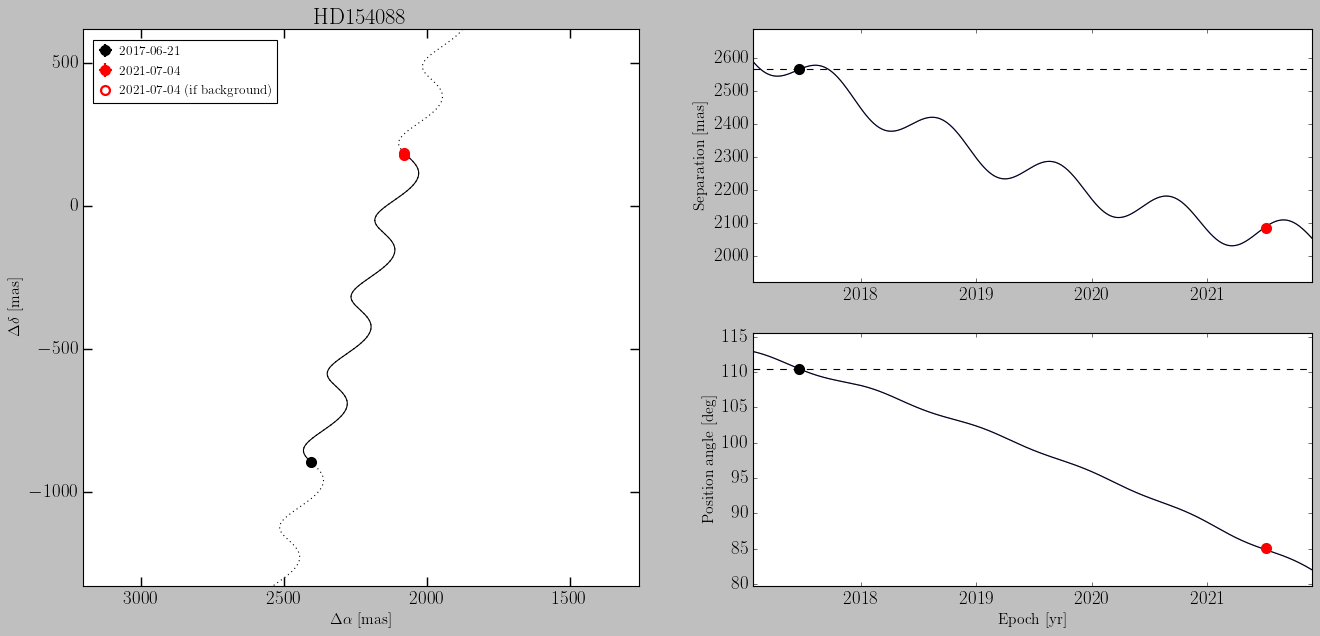

In [250]:
n_epochs = EPOCH.shape[0]

target   = target
dates    = [EPOCH[i][0] for i in range(n_epochs)]
dra      = [RA[i][0] for i in range(n_epochs)]
dra_err  = [RA_ERR[i][0] for i in range(n_epochs)]
ddec     = [DEC[i][0] for i in range(n_epochs)]
ddec_err = [DEC_ERR[i][0] for i in range(n_epochs)]

cond_select_obj = (target==dF_prop['target name'])
plx = float(dF_prop[cond_select_obj]['parallax'])
plx_err = float(dF_prop[cond_select_obj]['err parallax'])
dist = float(dF_prop[cond_select_obj]['distance'])
dist_err = plx_err/plx**2


# load some properties of the star from Simbad
result_table_names = customSimbad.query_object(target)

pm_err_star = np.max([result_table_names['PM_ERR_MAJA'][0],result_table_names['PM_ERR_MINA'][0]])
prop = {
    'ra': result_table_names['RA'][0],
    'dec': result_table_names['DEC'][0],
    'dist': dist,
    'dist_err': dist_err,
    'plx': plx,
    'plx_err': plx_err,
    'pm': [result_table_names['PMRA'][0],result_table_names['PMDEC'][0]],
    'pm_err': [pm_err_star,pm_err_star],
    #'pm_bkg': [-20, -30],
    #'pm_bkg_err': [6.5, 5.8]
}

fig, ax, RA_track, DEC_track, RA_expected_bkg, DEC_expected_bkg = proper_motion.plots(target, dates, 
                        dra, dra_err, ddec, ddec_err, prop, 
                        legend_loc=0, return_tracks=1, return_expected_positions=1)
mise_en_page(ax)
plt.savefig('PMD_{}_overview_{}epochs.pdf'.format(target,n_epochs))

#### Use a reference epoch to plot difference in relative declination vs difference in relative right ascension

In [257]:
#Parameters plot
color_background = 'blue'
color_detection = ['red', 'teal', 'orange', 'purple', 'magenta',  [0.9,0.8,0], 'navy', [0.4,0.4,1], [0.2,1,0.2], [0.5,1,0.5],  'cyan', [0,0,0.5],  [0.5,0,0],  [0.9,0.5,0.9],  [0.2,0.8,1], [0.5,0.5,0.5] , 'forestgreen']

In [235]:
len(color_detection)

17

- More than 1 candidate and than 1 epoch

1
2
1
2


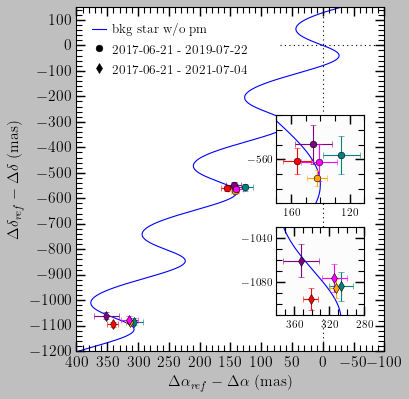

In [56]:
n_epochs = EPOCH.shape[0] ; n_candidates = EPOCH.shape[1]
xlab = r'$\Delta \alpha_{ref} - \Delta \alpha$ (mas)'
ylab = r'$\Delta \delta_{ref} - \Delta \delta$ (mas)'
target   = target
dates    = EPOCH
dra      = RA[1:]
dra_err  = [0]
ddec     = DEC[1:]
ddec_err = [0]

dra_ref      = RA[0]
dra_err_ref  = [0]
ddec_ref     = DEC[0]
ddec_err_ref = [0]

cond_select_obj = (target==dF_prop['target name'])
plx = float(dF_prop[cond_select_obj]['parallax'])
plx_err = float(dF_prop[cond_select_obj]['err parallax'])
dist = float(dF_prop[cond_select_obj]['distance'])
dist_err = plx_err/plx**2


fig, ax = plt.subplots(1,1,figsize=(5,5))
fig.subplots_adjust(left=0.18,bottom=0.11,top=0.97,right=0.95)
loc = 'upper left' ; add_zoom_text = '' ; marker_epoch = None
yfin_leg = 8000 ; ydeb_leg = -1e4 ; xdeb_leg = 1e4
color=color_detection ; label = ''
add_candidate = 0

axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong = 0.67, 0.45, 0.22, 0.22


# special cases : refined images providing the system
if target == 'GJ422' and n_epochs==3:
    xlim, ylim =  [600,-5700], [-600,3000] ; yfin_leg = 1800 #; loc = 'lower left'
    mise_en_page(ax,x_step=1,y_step=1,x_maj_step=1000, x_min_step=200, y_maj_step=1000, y_min_step=200)
    marker_epoch = ['o','d']
    add_candidate = 1
    add_zoom = 1
    xlim_zoom, ylim_zoom =  [-4400,-4500], [2150,2300] ;
    x_step_zoom=1; y_step_zoom=1 
    x_maj_step_zoom=50; x_min_step_zoom=10; y_maj_step_zoom=50; y_min_step_zoom=10
    axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong = 0.67, 0.45, 0.22, 0.22
    add_zoom_2 = 1
    axes2_xdeb2,axes2_ydeb2, axes2_xlong2,axes2_ylong2 = 0.67, 0.18, 0.22, 0.22
    xlim_zoom2, ylim_zoom2 =  [-4800,-4900], [2300,2400]

    
elif target == 'GJ682' and n_epochs==3:
    mise_en_page(ax,x_step=1,y_step=1,x_maj_step=500, x_min_step=100, y_maj_step=500, y_min_step=100)
    marker_epoch = ['o','d']
    xlim, ylim =  [200, -2000], [-2200,200] ; ydeb_leg = -1650 ; loc = 'lower left'
    add_zoom = 1 
    xlim_zoom, ylim_zoom =  [-120,-160], [-70,-35] ;
    x_step_zoom=1; y_step_zoom=1
    x_maj_step_zoom=20; x_min_step_zoom=5; y_maj_step_zoom=20; y_min_step_zoom=5
    axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong = 0.68, 0.69, 0.22, 0.22
    add_zoom_2 = 1
    axes2_xdeb2,axes2_ydeb2, axes2_xlong2,axes2_ylong2 = 0.68, 0.38, 0.22, 0.22
    xlim_zoom2, ylim_zoom2 =  [-1440,-1490], [-1920,-1860] ;
    
    
elif target == 'HD85512':
    mise_en_page(ax,x_step=1,y_step=1,x_maj_step=500, x_min_step=100, y_maj_step=500, y_min_step=100)
    marker_epoch = ['o','o','o','o']
    xlim, ylim =  [1500,-500], [-1500,200] ; xdeb_leg = 550#; ydeb_leg = -1500 ; loc = 'lower left'
    add_zoom = 0
    xlim_zoom, ylim_zoom =  [1395,1370], [-1370,-1250] ;
    x_step_zoom=1; y_step_zoom=1
    x_maj_step_zoom=10; x_min_step_zoom=5; y_maj_step_zoom=50; y_min_step_zoom=10
    axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong = 0.68, 0.46, 0.22, 0.22
    add_zoom_2 = 0
    axes2_xdeb2,axes2_ydeb2, axes2_xlong2,axes2_ylong2 = 0.68, 0.18, 0.22, 0.22
    xlim_zoom2, ylim_zoom2 =  [475,460], [-400,-350] ;
    
elif target == 'HD154088':
    xlim, ylim =  [400,-100], [-1200,150] ; xdeb_leg = 70
    marker_epoch = ['o','d']
    mise_en_page(ax,x_step=1,y_step=1,x_maj_step=50, x_min_step=10, y_maj_step=100, y_min_step=20)
    add_zoom = 1
    xlim_zoom, ylim_zoom =  [170,110], [-590,-530] ;
    x_step_zoom=1; y_step_zoom=1
    x_maj_step_zoom=40; x_min_step_zoom=10; y_maj_step_zoom=40; y_min_step_zoom=10
    axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong = 0.68, 0.48, 0.22, 0.22 
    add_zoom_2 = 1
    axes2_xdeb2,axes2_ydeb2, axes2_xlong2,axes2_ylong2 = 0.68, 0.2, 0.22, 0.22
    xlim_zoom2, ylim_zoom2 =  [380,280], [-1110,-1030] ;

# add background track
ax.plot(RA_track,DEC_track,label='bkg star w/o pm',color=color_background)

# add detections for each epoch
for t in range(1,n_epochs):
    print(t)
    XRA, YDEC = RA[0]-RA[t], DEC[0]-DEC[t]
    
    # ERRORBARS: define global error budget in RA, DEC
    # add the pupil offset error of theta = 0.1 deg; depends on sep (separation) and differs for ra/dec
    RA_ERR_PUPIL  = np.sqrt( (np.sin(theta)*SEP_ERR)**2 + (SEP*np.cos(theta)*theta_err)**2 ) #+ (np.sin(theta)*SEP_ERR[1])**2 + [SEP[1]*np.cos(theta)*theta_err]**2 )   
    DEC_ERR_PUPIL = np.sqrt( (np.cos(theta)*SEP_ERR)**2 + (SEP*np.sin(theta)*theta_err)**2 )  #+ (np.cos(theta)*SEP_ERR[1])**2 + [SEP[1]*np.sin(theta)*theta_err]**2 )   
    # global budget
    XRA_ERR  = np.sqrt(RA_ERR[0]**2+RA_ERR[t]**2+RA_ERR_PUPIL[0]**2+RA_ERR_PUPIL[t]**2)
    YDEC_ERR =  np.sqrt(DEC_ERR[0]**2+DEC_ERR[t]**2+DEC_ERR_PUPIL[0]**2+DEC_ERR_PUPIL[t]**2)

    for i in range(n_candidates):
        if t == 1 and add_candidate : label = 'candidate {}'.format(i+1)
        #ax.text(500,100,text,fontsize=12)
        ax.errorbar(XRA[i],YDEC[i],YDEC_ERR[i],XRA_ERR[i],label=label,
                marker=marker_epoch[t-1],color=color[i],lw=0, elinewidth=1, zorder=10)
    # add epochs in leg
    ax.plot([5e5,5e5],[5e5,5e5],color='black',marker=marker_epoch[t-1],lw=0,label='{} - {}'.format(EPOCH[0,0],EPOCH[t,0]))
    label = ''
    

# add [0,0] reference lines
ax.legend(loc=loc,frameon=False,numpoints=1)
ax.plot([0,0],[ydeb_leg,yfin_leg],ls=':',color='black')
fais_moi_un_subplot(ax,[xdeb_leg,-1e4],[0,0],ls=':',c='black',labx=xlab,laby=ylab)
plt.axis([xlim[0], xlim[1], ylim[0], ylim[1]])
#plt.gca().set_aspect('equal', adjustable='box')
#mise_en_page(ax,x_step=1,y_step=1,x_maj_step=100, x_min_step=20, y_maj_step=100, y_min_step=20)

# add second small plot
if add_zoom :
    add_zoom_text = '_zoom'
    axes2 = fig.add_axes([axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong]) # renvoie un objet Axes       
    #axes2.axis('equal')         
    axes2.patch.set_color([0.99,0.99,0.99])
    fais_moi_un_subplot(axes2,RA_track,DEC_track,c=color_background,fs=10,ls='-') #labx=xlab,laby=ylab
    # add detections for each epoch
    for t in range(1,n_epochs):
        print(t)
        XRA, YDEC = RA[0]-RA[t], DEC[0]-DEC[t]
        
        # ERRORBARS: define global error budget in RA, DEC
        # add the pupil offset error of theta = 0.1 deg; depends on sep (separation) and differs for ra/dec
        RA_ERR_PUPIL  = np.sqrt( (np.sin(theta)*SEP_ERR)**2 + (SEP*np.cos(theta)*theta_err)**2 ) #+ (np.sin(theta)*SEP_ERR[1])**2 + [SEP[1]*np.cos(theta)*theta_err]**2 )   
        DEC_ERR_PUPIL = np.sqrt( (np.cos(theta)*SEP_ERR)**2 + (SEP*np.sin(theta)*theta_err)**2 )  #+ (np.cos(theta)*SEP_ERR[1])**2 + [SEP[1]*np.sin(theta)*theta_err]**2 )   
        # global budget
        XRA_ERR  = np.sqrt(RA_ERR[0]**2+RA_ERR[t]**2+RA_ERR_PUPIL[0]**2+RA_ERR_PUPIL[t]**2)
        YDEC_ERR =  np.sqrt(DEC_ERR[0]**2+DEC_ERR[t]**2+DEC_ERR_PUPIL[0]**2+DEC_ERR_PUPIL[t]**2)
         
        for i in range(n_candidates):
            axes2.errorbar(XRA[i],YDEC[i],YDEC_ERR[i],XRA_ERR[i],label=label,
                    marker=marker_epoch[t-1],color=color[i],lw=0, elinewidth=1, zorder=10)
    axes2.axis([xlim_zoom[0], xlim_zoom[1], ylim_zoom[0], ylim_zoom[1]])
    if target == 'GJ422' and n_epochs == 3 :
        yti_old = [2150,2200,2250,2300]
        yti_new = ['$2150$','$2200$','$2250$','$2300$']
        plt.setp(axes2, yticks=yti_old, yticklabels=yti_new)
    mise_en_page(axes2,x_step=x_step_zoom,y_step=y_step_zoom,x_maj_step=x_maj_step_zoom, x_min_step=x_min_step_zoom, y_maj_step=y_maj_step_zoom, y_min_step=y_min_step_zoom)

if add_zoom_2 :
    add_zoom_text = '_zoom'
    axes2 = fig.add_axes([axes2_xdeb2,axes2_ydeb2, axes2_xlong2,axes2_ylong2]) # renvoie un objet Axes       
    #axes2.axis('equal')         
    axes2.patch.set_color([0.99,0.99,0.99])
    fais_moi_un_subplot(axes2,RA_track,DEC_track,c=color_background,fs=10,ls='-') #labx=xlab,laby=ylab
    # add detections for each epoch
    for t in range(1,n_epochs):
        XRA, YDEC = RA[0]-RA[t], DEC[0]-DEC[t]
        
        # ERRORBARS: define global error budget in RA, DEC
        # add the pupil offset error of theta = 0.1 deg; depends on sep (separation) and differs for ra/dec
        RA_ERR_PUPIL  = np.sqrt( (np.sin(theta)*SEP_ERR)**2 + (SEP*np.cos(theta)*theta_err)**2 ) #+ (np.sin(theta)*SEP_ERR[1])**2 + [SEP[1]*np.cos(theta)*theta_err]**2 )   
        DEC_ERR_PUPIL = np.sqrt( (np.cos(theta)*SEP_ERR)**2 + (SEP*np.sin(theta)*theta_err)**2 )  #+ (np.cos(theta)*SEP_ERR[1])**2 + [SEP[1]*np.sin(theta)*theta_err]**2 )   
        # global budget
        XRA_ERR  = np.sqrt(RA_ERR[0]**2+RA_ERR[t]**2+RA_ERR_PUPIL[0]**2+RA_ERR_PUPIL[t]**2)
        YDEC_ERR =  np.sqrt(DEC_ERR[0]**2+DEC_ERR[t]**2+DEC_ERR_PUPIL[0]**2+DEC_ERR_PUPIL[t]**2)

        for i in range(n_candidates):
            axes2.errorbar(XRA[i],YDEC[i],YDEC_ERR[i],XRA_ERR[i],label=label,
                    marker=marker_epoch[t-1],color=color[i],lw=0, elinewidth=1, zorder=10)

    axes2.axis([xlim_zoom2[0], xlim_zoom2[1], ylim_zoom2[0], ylim_zoom2[1]])
    if target == 'GJ422' and n_epochs == 3 :
        yti_old = [2300,2350,2400]
        yti_new = ['$2300$','$2350$','$2400$']
        plt.setp(axes2, yticks=yti_old, yticklabels=yti_new)
        
    if target == 'GJ682' and n_epochs == 3  :
        xti_old = [-1480,-1460,-1440]
        xti_new = ['$-1480$','$-1460$','$-1440$']
        plt.setp(axes2, xticks=xti_old, xticklabels=xti_new)
        
    if target == 'HD154088' and n_epochs == 3  :
        yti_old = [-1040,-1080]
        yti_new = ['$-1040$','$-1080$']
        plt.setp(axes2, yticks=yti_old, yticklabels=yti_new)
    
    mise_en_page(axes2,x_step=x_step_zoom,y_step=y_step_zoom,x_maj_step=x_maj_step_zoom, x_min_step=x_min_step_zoom, y_maj_step=y_maj_step_zoom, y_min_step=y_min_step_zoom)


plt.savefig('PMD_{}_3epochs{}.pdf'.format(target,add_zoom_text))
plt.savefig('PMD_{}_3epochs{}.png'.format(target,add_zoom_text))

- 2 epochs and at least 1 candidate

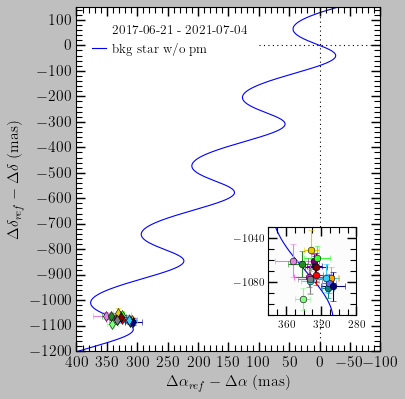

In [259]:
n_epochs = EPOCH.shape[0]
n_candidates = EPOCH.shape[1]

xlab = r'$\Delta \alpha_{ref} - \Delta \alpha$ (mas)'
ylab = r'$\Delta \delta_{ref} - \Delta \delta$ (mas)'
target   = target
dates    = EPOCH
dra      = RA[1:]
dra_err  = [0]
ddec     = DEC[1:]
ddec_err = [0]

dra_ref      = RA[0]  ; dra_err_ref  = [0]
ddec_ref     = DEC[0] ; ddec_err_ref = [0]

cond_select_obj = (target==dF_prop['target name'])
plx = float(dF_prop[cond_select_obj]['parallax'])
plx_err = float(dF_prop[cond_select_obj]['err parallax'])
dist = float(dF_prop[cond_select_obj]['distance'])
dist_err = plx_err/plx**2

# define global error budget in RA, DEC
# add the pupil offset error of theta = 0.1 deg; depends on sep (separation) and differs for ra/dec
# error in ra: dra**2 =  [sin(theta)*dsep]**2 + [sep*cos(theta)*dtheta]**2 
# error in dec: ddec**2 =  [cos(theta)*dsep]**2 + [sep*sin(theta)*dtheta]**2 
theta     = 135.99 * np.pi/180 # 0.1 error pupil offset converted in rad
theta_err = 0.11 * np.pi/180 

# difference of positionf of two candidates so errors have to be taken into account for each candidates (~ x2)
XRA, YDEC = RA[0]-RA[1], DEC[0]-DEC[1]
RA_ERR_PUPIL  = np.sqrt( (np.sin(theta)*SEP_ERR)**2 + (SEP*np.cos(theta)*theta_err)**2 ) #+ (np.sin(theta)*SEP_ERR[1])**2 + [SEP[1]*np.cos(theta)*theta_err]**2 )   
DEC_ERR_PUPIL = np.sqrt( (np.cos(theta)*SEP_ERR)**2 + (SEP*np.sin(theta)*theta_err)**2 )  #+ (np.cos(theta)*SEP_ERR[1])**2 + [SEP[1]*np.sin(theta)*theta_err]**2 )   
# global budget
XRA_ERR  = np.sqrt(RA_ERR[0]**2+RA_ERR[1]**2+RA_ERR_PUPIL[0]**2+RA_ERR_PUPIL[1]**2)
YDEC_ERR =  np.sqrt(DEC_ERR[0]**2+DEC_ERR[1]**2+DEC_ERR_PUPIL[0]**2+DEC_ERR_PUPIL[1]**2)

fig, ax = plt.subplots(1,1,figsize=(5,5))
fig.subplots_adjust(left=0.18,bottom=0.11,top=0.97,right=0.94)
loc = 'upper left' ; add_zoom_text = '' ; xdeb_leg = 1e4 ;  ydeb_leg = -1e4 ; yfin_leg = 1e4 ; ncol = 1


# mise en page
add_zoom = 0
axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong = 0.67, 0.45, 0.22, 0.22
xlim_zoom, ylim_zoom =  [-350,-440], [50,180] ;
x_step_zoom=0; y_step_zoom=0 ; x_maj_step_zoom=20; x_min_step_zoom=5; y_maj_step_zoom=20; y_min_step_zoom=5
marker = 'o'

ax.plot([500,500],[500,500],color='white',marker=None,label='{} - {}'.format(EPOCH[0,0],EPOCH[1,0]))

# add detections for each epoch
for i in range(n_candidates):
    if target != 'HD154088' :
        label = 'candidate {}'.format(i+1)
    else : 
        marker = 'd'
        if color_detection[i] == 'black' : label = 'candidates'.format(i+1)
        else : label =''
    #ax.text(500,100,text,fontsize=12)
    ax.errorbar(XRA[i],YDEC[i],YDEC_ERR[i],XRA_ERR[i],label=label,
            marker=marker,color=color_detection[i],lw=0, elinewidth=1, zorder=10)

# add background track
ax.plot(RA_track,DEC_track,label='bkg star w/o pm',color=color_background)

#ax.axis('equal')
if target == 'HD154088':
    xlim, ylim =  [400,-100], [-1200,150] ; xdeb_leg = 100
    mise_en_page(ax,x_step=1,y_step=1,x_maj_step=50, x_min_step=10, y_maj_step=100, y_min_step=20)
    add_zoom = 1
    xlim_zoom, ylim_zoom =  [380,280], [-1110,-1030] ;
    x_step_zoom=1; y_step_zoom=1 
    x_maj_step_zoom=40; x_min_step_zoom=10; y_maj_step_zoom=40; y_min_step_zoom=10
    axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong = 0.66, 0.2, 0.22, 0.22

elif target == 'HD136352':
    xlim, ylim =  [600,-4600], [-1000,100] ; ydeb_leg = -360 ; xdeb_leg = 5000 ; loc = 'lower left'
    mise_en_page(ax,x_step=1,y_step=1,x_maj_step=1000, x_min_step=200, y_maj_step=200, y_min_step=50)
    add_zoom = 1 ; x_step_zoom=1; y_step_zoom=1
    xlim_zoom, ylim_zoom =  [-4195,-4240], [-790,-740] ;
    x_maj_step_zoom=20; x_min_step_zoom=5; y_maj_step_zoom=20; y_min_step_zoom=5
    axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong = 0.69, 0.7, 0.22, 0.22
    
elif target == 'GJ433':
    xlim, ylim =  [200,-300], [-2000,200] ;loc = 'lower left' ; ydeb_leg = -1500
    mise_en_page(ax,x_step=1,y_step=1,x_maj_step=100, x_min_step=20, y_maj_step=500, y_min_step=100)
    add_zoom = 1
    xlim_zoom, ylim_zoom =  [-100,-135], [-1680,-1640] ;
    x_step_zoom=1; y_step_zoom=1
    x_maj_step_zoom=10; x_min_step_zoom=5; y_maj_step_zoom=20; y_min_step_zoom=5
    axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong = 0.29, 0.6, 0.22, 0.22
    
    
elif target == 'GJ422' and n_epochs==2:
    xlim, ylim =  [100,-1200], [-50,440] ; xdeb_leg = 1000 ; yfin_leg =220#; loc = 'lower left'
    mise_en_page(ax,x_step=1,y_step=1,x_maj_step=200, x_min_step=100, y_maj_step=100, y_min_step=20)
    add_zoom = 1
    xlim_zoom, ylim_zoom =  [-350,-440], [50,180] ;
    x_step_zoom=1; y_step_zoom=1 
    x_maj_step_zoom=40; x_min_step_zoom=10; y_maj_step_zoom=40; y_min_step_zoom=10
    axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong = 0.67, 0.25, 0.22, 0.22
    
elif target == 'GJ682' and n_epochs==2:
    xlim, ylim =  [20,-200], [-120,10] ; ydeb_leg = -65 ; loc = 'lower left' ; ncol= 2
    xlim_zoom, ylim_zoom =  [-120,-160], [-70,-35] ;
    mise_en_page(ax,x_step=1,y_step=1,x_maj_step=100, x_min_step=20, y_maj_step=20, y_min_step=5)
    x_step_zoom=1; y_step_zoom=1 
    x_maj_step_zoom=20; x_min_step_zoom=5; y_maj_step_zoom=20; y_min_step_zoom=5
    axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong = 0.65, 0.7, 0.22, 0.22
    add_zoom = 1

elif target == 'GJ832':
    xlim, ylim =  [50,-200], [-200,50]  ; ydeb_leg = -200 ; loc = 'upper right' ; ncol= 1
    xlim_zoom, ylim_zoom =  [-120,-160], [-70,-35] ;
    mise_en_page(ax,x_step=1,y_step=1,x_maj_step=50, x_min_step=10, y_maj_step=50, y_min_step=10)
    x_step_zoom=1; y_step_zoom=1 
    x_maj_step_zoom=20; x_min_step_zoom=5; y_maj_step_zoom=20; y_min_step_zoom=5
    axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong = 0.65, 0.7, 0.22, 0.22
    add_zoom = 0
     

# add [0,0] reference lines
ax.legend(loc=loc,frameon=False,numpoints=1,ncol=ncol)
ax.plot([0,0],[ydeb_leg,yfin_leg],ls=':',color='black')
fais_moi_un_subplot(ax,[xdeb_leg,-1e4],[0,0],ls=':',c='black',labx=xlab,laby=ylab)
plt.axis([xlim[0], xlim[1], ylim[0], ylim[1]])
#plt.gca().set_aspect('equal', adjustable='box')
#mise_en_page(ax,x_step=1,y_step=1,x_maj_step=100, x_min_step=20, y_maj_step=100, y_min_step=20)

# add second small plot
if add_zoom :
    add_zoom_text = '_zoom'
    axes2 = fig.add_axes([axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong]) # renvoie un objet Axes       
    #axes2.axis('equal')         
    axes2.patch.set_color([0.99,0.99,0.99])
    fais_moi_un_subplot(axes2,RA_track,DEC_track,c=color_background,fs=10,ls='-') #labx=xlab,laby=ylab
    # add detections for each epoch
    for i in range(n_candidates):
        axes2.errorbar(XRA[i],YDEC[i],YDEC_ERR[i],XRA_ERR[i],label=label,
            marker='o',color=color_detection[i],lw=0, elinewidth=1, zorder=10)
 
    axes2.axis([xlim_zoom[0], xlim_zoom[1], ylim_zoom[0], ylim_zoom[1]])
    mise_en_page(axes2,x_step=x_step_zoom,y_step=y_step_zoom,x_maj_step=x_maj_step_zoom, x_min_step=x_min_step_zoom, y_maj_step=y_maj_step_zoom, y_min_step=y_min_step_zoom)
    
    if target == 'HD136352' and n_epochs == 2 :
        xti_old = [-4190,-4230,-4210]
        xti_new = ['$-4190$','$-4230$','$-4210$']
        plt.setp(axes2, xticks=xti_old, xticklabels=xti_new)
        
    if target == 'GJ433':
        yti_old = [-1680,-1660,-1640]
        yti_new = ['$-1680$','$-1660$','$-1640$']
        plt.setp(axes2, yticks=yti_old, yticklabels=yti_new)
        
    if target == 'HD154088' and n_epochs == 2  :
        yti_old = [-1040,-1080]
        yti_new = ['$-1040$','$-1080$']
        plt.setp(axes2, yticks=yti_old, yticklabels=yti_new)

plt.savefig('PMD_{}_2epochs{}.pdf'.format(target,add_zoom_text))
plt.savefig('PMD_{}_2epochs{}.png'.format(target,add_zoom_text))

In [ ]:
## general ##


In [237]:
XRA

array([  325.89,   312.43,   308.78,   328.46,   476.97, -5963.15,
        4194.7 ,   668.53,  8088.6 , -4322.06, -2236.09,  8768.95,
        -449.76, -1596.27,  4722.73,  3103.01, -3069.88])

In [238]:
YDEC

array([-1073.47, -1085.64, -1076.04, -1061.01, -1928.16,  2199.46,
        3617.13, -1053.01, -3774.91,  4288.7 ,  2626.21, -1309.14,
       -9073.93, -6085.71,  7055.67,  5970.43,  6249.93])

In [ ]:
for i in range(n_candidates):
    print('%.2f'%XRA[i], '%.2f'%YDEC[i], 'error', '%.2f'%XRA_ERR[i], '%.2f'%YDEC_ERR[i])

In [80]:
color_detection = 'red'

In [81]:
i=0
print(DEC[0,i]-DEC[1,i])

-93.30000000000001


- More than 2 epochs but only 1 candidate

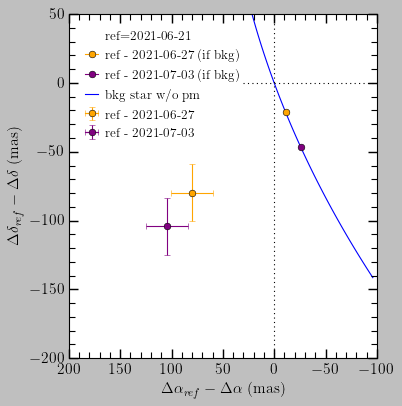

In [105]:
add_zoom = 1 

xlab = r'$\Delta \alpha_{ref} - \Delta \alpha$ (mas)'
ylab = r'$\Delta \delta_{ref} - \Delta \delta$ (mas)'
target   = target
dates    = EPOCH

dra_ref      = RA[0]  ; dra_err_ref  = RA_ERR[0]
ddec_ref     = DEC[0] ; ddec_err_ref = DEC_ERR[0]

XRA,YDEC = dra_ref-RA, ddec_ref-DEC

# ERRORBARS: define global error budget in RA, DEC
# add the pupil offset error of theta = 0.1 deg; depends on sep (separation) and differs for ra/dec
RA_ERR_PUPIL  = np.sqrt( (np.sin(theta)*SEP_ERR)**2 + (SEP*np.cos(theta)*theta_err)**2 ) #+ (np.sin(theta)*SEP_ERR[1])**2 + [SEP[1]*np.cos(theta)*theta_err]**2 )   
DEC_ERR_PUPIL = np.sqrt( (np.cos(theta)*SEP_ERR)**2 + (SEP*np.sin(theta)*theta_err)**2 )  #+ (np.cos(theta)*SEP_ERR[1])**2 + [SEP[1]*np.sin(theta)*theta_err]**2 )   
# global budget
XRA_ERR  = np.sqrt(RA_ERR[0]**2+RA_ERR**2+RA_ERR_PUPIL[0]**2+RA_ERR_PUPIL**2)
YDEC_ERR =  np.sqrt(DEC_ERR[0]**2+DEC_ERR**2+DEC_ERR_PUPIL[0]**2+DEC_ERR_PUPIL**2)

cond_select_obj = (target==dF_prop['target name'])
plx = float(dF_prop[cond_select_obj]['parallax'])
plx_err = float(dF_prop[cond_select_obj]['err parallax'])
dist = float(dF_prop[cond_select_obj]['distance'])
dist_err = plx_err/plx**2

fig, ax = plt.subplots(1,1,figsize=(5,5))
fig.subplots_adjust(left=0.18,bottom=0.11,top=0.97,right=0.95)
plot_expected_positions_bkg=0 ;  xfin_leg = -50;

ax.plot([500,500],[500,500],color='white',marker=None,label='ref={}'.format(EPOCH[0,0]))
# add detections for each epoch
n = len(RA) ; RSM = 1
if target == 'GJ832' and not RSM:
    n = 2
for i in range(1,n):
    label = 'ref - {1}'.format(EPOCH[0,0],EPOCH[i,0])
    ax.errorbar(XRA[i],YDEC[i],YDEC_ERR[i],XRA_ERR[i],label=label,
            marker='o',color=color_detection[i+1],lw=1, zorder=10,elinewidth=1)
    
if target == 'HD85512':
    mise_en_page(ax,x_step=1,y_step=1,x_maj_step=500, x_min_step=100, y_maj_step=500, y_min_step=100)
    marker_epoch = ['o','d']
    xlim, ylim =  [1500,-500], [-1500,200] ; xdeb_leg = 550; loc ='upper left'#; ydeb_leg = -1500 ; loc = 'lower left'
    add_zoom = 1
    xlim_zoom, ylim_zoom =  [1410,1360], [-1370,-1250] ;
    x_step_zoom=1; y_step_zoom=1
    x_maj_step_zoom=50; x_min_step_zoom=10; y_maj_step_zoom=50; y_min_step_zoom=10
    axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong = 0.68, 0.46, 0.22, 0.22
    add_zoom_2 = 1
    axes2_xdeb2,axes2_ydeb2, axes2_xlong2,axes2_ylong2 = 0.68, 0.18, 0.22, 0.22
    xlim_zoom2, ylim_zoom2 =  [500,450], [-400,-350] ;
    
elif target == 'GJ832':
    xlim, ylim =  [200,-100], [-200,50]  ; xdeb_leg = 30 ; xfin_leg = -200 ; yfin_leg = -80 ; ydeb_leg = -200 ; loc = 'upper left' ; ncol= 1
    xlim_zoom, ylim_zoom =  [-120,-160], [-70,-35] ;
    mise_en_page(ax,x_step=1,y_step=1,x_maj_step=50, x_min_step=10, y_maj_step=50, y_min_step=10)
    x_step_zoom=1; y_step_zoom=1 
    x_maj_step_zoom=20; x_min_step_zoom=5; y_maj_step_zoom=20; y_min_step_zoom=5
    axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong = 0.65, 0.7, 0.22, 0.22
    add_zoom = 0 ; add_zoom_2 = 0 ; plot_expected_positions_bkg = 1
    
elif target == 'GJ832' and 1: # RSM
    xlim, ylim =  [400,-100], [-200,50]  ; xdeb_leg = 30 ; xfin_leg = -200 ; yfin_leg = -80 ; ydeb_leg = -200 ; loc = 'upper left' ; ncol= 1
    xlim_zoom, ylim_zoom =  [-120,-160], [-70,-35] ;
    mise_en_page(ax,x_step=1,y_step=1,x_maj_step=50, x_min_step=10, y_maj_step=50, y_min_step=10)
    x_step_zoom=1; y_step_zoom=1 
    x_maj_step_zoom=20; x_min_step_zoom=5; y_maj_step_zoom=20; y_min_step_zoom=5
    axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong = 0.65, 0.7, 0.22, 0.22
    add_zoom = 0 ; add_zoom_2 = 0 ; plot_expected_positions_bkg = 1
     

if plot_expected_positions_bkg: 
    XRA_expected_bkg,YDEC_expected_bkg = dra_ref-RA_expected_bkg, ddec_ref-DEC_expected_bkg
    for i in range(len(RA_expected_bkg)):
        label = 'ref - {1} (if bkg)'.format(EPOCH[0,0],EPOCH[1+i,0])
        ax.plot(XRA_expected_bkg[i],YDEC_expected_bkg[i],label=label,
                marker='o',color=color_detection[2+i],lw=1, zorder=10)
        
# add background track
ax.plot(RA_track,DEC_track,label='bkg star w/o pm',color=color_background)
# add [0,0] reference lines
ax.plot([0,0],[-1e4,1e3],ls=':',color='black')
fais_moi_un_subplot(ax,[xdeb_leg,xfin_leg],[0,0],ls=':',c='black',labx=xlab,laby=ylab)
ax.legend(loc=loc,frameon=False,numpoints=1)
#ax.axis('equal')
plt.axis([xlim[0], xlim[1], ylim[0], ylim[1]])
#plt.gca().set_aspect('equal', adjustable='box')
#mise_en_page(ax,x_step=1,y_step=1,x_maj_step=500, x_min_step=100,y_maj_step=500, y_min_step=100)

legend_without_duplicate_labels(ax,loc=loc,frameon=False,numpoints=1)
    
# add second small plot
if add_zoom :
    add_zoom_text = '_zoom'
    axes2 = fig.add_axes([axes2_xdeb,axes2_ydeb, axes2_xlong,axes2_ylong]) # renvoie un objet Axes       
    #axes2.axis('equal')         
    axes2.patch.set_color([0.99,0.99,0.99])
    fais_moi_un_subplot(axes2,RA_track,DEC_track,c=color_background,fs=10,ls='-') #labx=xlab,laby=ylab
    # add detections for each epoch
    for i in range(1,len(RA)):
        axes2.errorbar(XRA[i],YDEC[i],YDEC_ERR[i],XRA_ERR[i],label=label,
                marker='o',color=color_detection[i],lw=0, elinewidth=1, zorder=10)

    axes2.axis([xlim_zoom[0], xlim_zoom[1], ylim_zoom[0], ylim_zoom[1]])
    mise_en_page(axes2,x_step=x_step_zoom,y_step=y_step_zoom,x_maj_step=x_maj_step_zoom, x_min_step=x_min_step_zoom, y_maj_step=y_maj_step_zoom, y_min_step=y_min_step_zoom)
    if target == 'HD85512' :
        xti_old = [1400,1350]
        xti_new = ['$1400$','$1350$']
        plt.setp(axes2, xticks=xti_old, xticklabels=xti_new)
    
    
if add_zoom_2 :
    add_zoom_text = '_zoom'
    axes2 = fig.add_axes([axes2_xdeb2,axes2_ydeb2, axes2_xlong2,axes2_ylong2]) # renvoie un objet Axes       
    #axes2.axis('equal')         
    axes2.patch.set_color([0.99,0.99,0.99])
    fais_moi_un_subplot(axes2,RA_track,DEC_track,c=color_background,fs=10,ls='-') #labx=xlab,laby=ylab
    # add detections for each epoch
    for i in range(1,len(RA)):
        axes2.errorbar(XRA[i],YDEC[i],YDEC_ERR[i],XRA_ERR[i],label=label,
                marker='o',color=color_detection[i],lw=0, elinewidth=1, zorder=10)

    axes2.axis([xlim_zoom2[0], xlim_zoom2[1], ylim_zoom2[0], ylim_zoom2[1]])
    mise_en_page(axes2,x_step=x_step_zoom,y_step=y_step_zoom,x_maj_step=x_maj_step_zoom, x_min_step=x_min_step_zoom, y_maj_step=y_maj_step_zoom, y_min_step=y_min_step_zoom)

    
plt.savefig('PMD_{}_{}epochs{}_RSM.pdf'.format(target,len(EPOCH),add_zoom_text))
plt.savefig('PMD_{}_{}epochs{}_RSM.png'.format(target,len(EPOCH),add_zoom_text))

In [68]:
RA_expected_bkg

[-444.67275541359226, -431.38399044378843, -416.66708247498497]

In [38]:
print(dra_ref, ddec_ref)

-444.67275541359226 302.1698353611517


In [55]:
print(XRA_expected_bkg+dra_ref)
print(YDEC_expected_bkg+ddec_ref)

[-517.72724459 -531.01600956 -545.73291753]
[93.23016464 67.51056332 42.20296998]


In [56]:
print(RA_expected_bkg)
print(DEC_expected_bkg)

[-444.67275541359226, -431.38399044378843, -416.66708247498497]
[302.1698353611517, 327.8894366819021, 353.19703001833506]


In [31]:
XRA_expected_bkg,YDEC_expected_bkg 

(array([  0.        , -13.28876497, -28.00567294]),
 array([  0.        , -25.71960132, -51.02719466]))

In [34]:
XRA,YDEC

(array([[  0. ],
        [-52.2],
        [-52.2],
        [-52.2]]),
 array([[  0. ],
        [-93.3],
        [-93.3],
        [-93.3]]))

In [32]:
RA_expected_bkg

[-444.67275541359226, -431.38399044378843, -416.66708247498497]

In [ ]:
for i in range (1,3):
    print(dra_ref-RA[i],ddec_ref-DEC[i])

- PMD basic : shows 1 candidate between 2 epochs

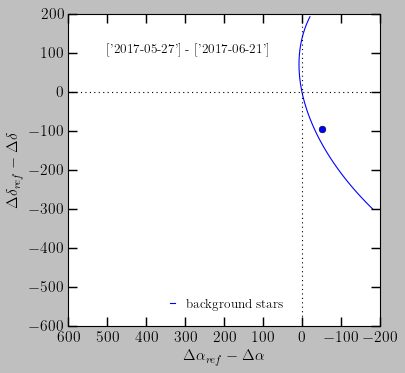

In [84]:
xlab = r'$\Delta \alpha_{ref} - \Delta \alpha$'
ylab = r'$\Delta \delta_{ref} - \Delta \delta$'
target   = target
dates    = EPOCH[:2]
dra      = RA[1]
dra_err  = [0]
ddec     = DEC[1]
ddec_err = [0]

dra_ref      = RA[0]
dra_err_ref  = [0]
ddec_ref     = DEC[0]
ddec_err_ref = [0]

cond_select_obj = (target==dF_prop['target name'])
plx = float(dF_prop[cond_select_obj]['parallax'])
plx_err = float(dF_prop[cond_select_obj]['err parallax'])
dist = float(dF_prop[cond_select_obj]['distance'])
dist_err = plx_err/plx**2

fig, ax = plt.subplots(1,1,figsize=(5,5))
fig.subplots_adjust(left=0.17,bottom=0.15,top=0.95,right=0.95)

text = '{} - {}'.format(EPOCH[0],EPOCH[1])
color_background = 'blue'
ax.text(500,100,text,fontsize=12)
xlim, ylim =  [1000,-4200], [-3000,1000]
ax.axis('equal')
ax.plot(RA_track,DEC_track,label='background stars',color=color_background)
ax.plot(dra_ref-dra,ddec_ref-ddec,marker='o',color=color_background)
ax.plot([0,0],[-1e4,1e3],ls=':',color='black')
fais_moi_un_subplot(ax,[-1e4,1e3],[0,0],ls=':',c='black',labx=xlab,laby=ylab)

ax.legend(loc='lower center',frameon=False)
xlim, ylim =  [600,-200], [-600,200]
plt.axis([xlim[0], xlim[1], ylim[0], ylim[1]])
plt.gca().set_aspect('equal', adjustable='box')
mise_en_page(ax)
plt.savefig('{}_difference_epochs_{}_{}_allH23.pdf'.format(target,EPOCH[0],EPOCH[1]))

=====================================================================================================================

## Extra: Prepare tables

#### Print list of the targets

In [ ]:
for i in range(len(dF_prop)):
    parallax_star = PARALLAX[i]*1e-3 ; parallax_err_star = PARALLAX_ERR[i]*1e-3
    mag_H, mag_K =MAG_STAR_H[i], MAG_STAR_K[i]
    target = NAME_OBJ[i]
    d_star = 1/parallax_star
    d_err_star = parallax_err_star/parallax_star**2
    print(target, '&' #'& %.2f'% (parallax_star*1e3), '\pm %.2f'% (parallax_err_star*1e3),'& %.2f'% d_star,
          #'& %.2f'% mag_H, '& %.2f'% mag_K
         )
          #, '& %.2f'% d_err_star)

#### Print list of the detections

In [ ]:
NIGHT_OBS = np.array(dF_obs['night_obs'])
NAME_OBJ_obs  = np.array(dF_obs['target name'])
FILTER_IRDIS_OBS = np.array(dF_obs['IRDIS filter'])
FILTER_IFS_OBS = np.array(dF_obs['IFS disperser'])
for i in range(len(dF_prop)):
    target = NAME_OBJ[i]
    i_selected = (NAME_OBJ_obs == target)
    dF_obs_1target = dF_obs[i_selected]
    for k in range(len(NIGHT_OBS[i_selected])):
        night_obs = NIGHT_OBS[i_selected][k]
        filt_ird = FILTER_IRDIS_OBS[i_selected][k][2:]
        filt_ifs = FILTER_IFS_OBS[i_selected][k][4:]
        if k % 2 == 0 : # IRDIS
            print(target,'&',night_obs,'&',filt_ird,'&')
        else : # IFS
            print(target,'&',night_obs,'&',filt_ifs,'&')
    #print(target, '&' #'& %.2f'% (parallax_star*1e3), '\pm %.2f'% (parallax_err_star*1e3),'& %.2f'% d_star,
          #'& %.2f'% mag_H, '& %.2f'% mag_K
    #     )
          #, '& %.2f'% d_err_star)